In [165]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IDC Tutorial: Tissue classification in slide microscopy images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/cptac_use_case.ipynb)

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al. 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


## Customization

Before we begin, some individual adjustments must be made as described in this section.

This notebook is intended to be run using a **GPU**. In Google Colab, GPU usage can be enabled via `Edit > Notebooks Settings > Hardware accelerator`. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with. \
During the first steps of the notebook (which do not utilize the GPU) Colab might ask if you want to switch back to a CPU. If so, please deny that. 

In [59]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

True ['GPU 0: Tesla T4 (UUID: GPU-287a6fb7-9d59-2ccf-934f-b92961fa8d73)']


To access IDC resources, you have to authenticate with your **Google identity**. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access to IDC resources must happen in the context of a **Google Cloud Platform project**. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). Set `my_project_id` below to the ID of your GCP project.

In [60]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y subversion 
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/idc_pathomics # use master instead of development branch later

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install the [OpenSlide](https://openslide.org/api/python/) library for accessing whole-slide images.

In [81]:
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-pil
Suggested packages:
  python-pil-doc python3-pil-dbg
Recommended packages:
  python-openslide-examples python3-olefile
The following NEW packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-openslide python3-pil
0 upgraded, 5 newly installed, 0 to remove and 1 not upgraded.
Need to get 0 B/619 kB of archives.
After this operation, 1990 kB of additional disk space will be used.
Selecting previously unselected package libimagequant0:amd64.
(Reading database ... 115336 files and directories currently installed.)
Preparing to unpack .../libimagequant0_2.12.2-1.1_amd64.deb ...
Unpacking libimagequant0:amd64 (2.12.2-1.1) ...
Selecting previously unselected package libopenslide0.
Preparing to unpack .../libopenslide0_3.4.1+dfsg-4_amd64.deb ...
Unpacking libopensl

Import the required Python modules.

In [147]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [148]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter


Create directories for input and output data.

In [290]:
#input_dir = os.path.join(curr_dir[-1], 'idc_input')
#output_dir = os.path.join(curr_dir[-1], 'idc_output')
# Use the following paths if using a Google Cloud VM instead of Google Colab
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.

Metadata for the DICOM files—including standard DICOM tags, but also non-DICOM metadata—are stored in the BigQuery table `dicom_all`. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) using the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [321]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM idc-dev-etl.idc_v3.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 6688.71rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 20x magnification (corresponding to a pixel spacing between 0.00025 and 0.00051 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 5th slide to make the dataset small enough to be manageable in Google Colab.

In [322]:
slides_df.query('pixel_spacing > 0.00025 & pixel_spacing < 0.00051 & compression=="jpeg"', inplace=True)
slides_df = slides_df.sample(frac=1).reset_index(drop=True) # shuffle rows
slides_df.sort_values(by='dataset', inplace=True)
slides_df = slides_df.iloc[::7, :] # select every 5th row 

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression
0,C3L-00094-21,C3L-00094,CPTAC-LUAD,23903,25971,1.3.6.1.4.1.5962.99.1.2431708067.494681296.162...,gs://idc_dev/c8fd7e19-f3c8-4e57-b754-cd1d1c6d3...,0.000494,jpeg
5,C3L-00445-24,C3L-00445,CPTAC-LSCC,91631,39211,1.3.6.1.4.1.5962.99.1.2441095712.2105263806.16...,gs://idc_dev/b477bc61-fa56-4268-a42f-d85c7e918...,0.000494,jpeg
6,C3L-00445-22,C3L-00445,CPTAC-LSCC,93623,33164,1.3.6.1.4.1.5962.99.1.2457602447.1341271939.16...,gs://idc_dev/4a0c4019-a079-4e04-be1c-9d4da0802...,0.000494,jpeg
8,C3L-00503-24,C3L-00503,CPTAC-LSCC,25895,25055,1.3.6.1.4.1.5962.99.1.2445286746.1235678009.16...,gs://idc_dev/c9ada473-f960-41f6-a515-f550c9e02...,0.000494,jpeg
11,C3L-00993-21,C3L-00993,CPTAC-LSCC,29879,25274,1.3.6.1.4.1.5962.99.1.2459476421.848889295.162...,gs://idc_dev/97173d83-671e-442c-81f7-f4215dcb9...,0.000494,jpeg


The tissue type of the slides (tumor or normal) is not yet included in the `dicom_all` table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [300]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [301]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,C3L-00009-21,C3L-00009,CPTAC-LUAD,19919,21869,1.3.6.1.4.1.5962.99.1.2458217402.297621157.162...,gs://idc_dev/49b5c8c1-890d-488b-978f-c866ce796...,0.000494,jpeg,tumor,luad
1,C3L-00094-26,C3L-00094,CPTAC-LUAD,33863,32611,1.3.6.1.4.1.5962.99.1.2436962939.2006513309.16...,gs://idc_dev/58e1a1d5-5fea-4e70-bd5c-8af70b71b...,0.000494,jpeg,normal,luad
2,C3L-00263-21,C3L-00263,CPTAC-LUAD,35855,30785,1.3.6.1.4.1.5962.99.1.2436628514.852093794.162...,gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803...,0.000494,jpeg,tumor,luad
3,C3L-00444-26,C3L-00444,CPTAC-LUAD,95615,36620,1.3.6.1.4.1.5962.99.1.2459291949.1418360092.16...,gs://idc_dev/6c60bc49-4275-4fab-a338-a7ff8aa11...,0.000494,jpeg,normal,luad
4,C3L-00445-23,C3L-00445,CPTAC-LSCC,85655,35614,1.3.6.1.4.1.5962.99.1.2462517922.1951470674.16...,gs://idc_dev/d9172527-9c46-4756-89d6-766b126d8...,0.000494,jpeg,normal,lscc


Total number of slides:  304
--> 149 slides from 111 LUAD patients
--> 155 slides from 109 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

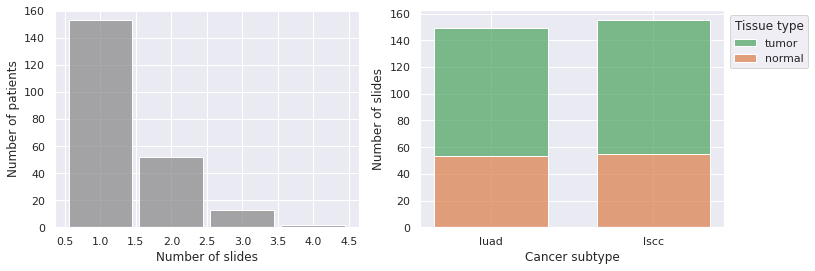

In [302]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})

# distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C2', 'C1'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily viewed and explored in detail using the IDC viewer.

In [303]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2458217402.297621157.1625955888058.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2465911408.281290669.1625963582064.3.0


Finally, we save the information as CSV file `slides_metadata.csv` to be used later for splitting into training, validation and test sets.

In [304]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment consists of three main steps:

1. **Preprocessing**:
    - Tiling of slides and filtering out of background tiles
    - Separation into training, validation and test dataset
2. **Training**: Per-tile training of the model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` given the respective gcs_url's. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this experiment is supposed to serve as a demo requiring a minimum amount of runtime, we further reduce the size of our dataset by generating only one in `twenty` tiles per slide. Still the tile generation will take roughly **xxx** time. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles available from each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [305]:
from idc_pathomics.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
if not os.path.exists(slides_dir):
    os.makedirs(slides_dir)

if not os.path.exists(tiles_dir):
    os.makedirs(tiles_dir)

generate_tiles(slides_dir, slides_metadata_path, tiles_dir, save_every_xth_tile=5, google_cloud_project_id=my_project_id)

1/304


Copying gs://idc_dev/49b5c8c1-890d-488b-978f-c866ce796acb.dcm...


Processing slide C3L-00009-21 - 2021-09-25 19:50:04.435033


\ [1 files][109.1 MiB/109.1 MiB]                                                
Operation completed over 1 objects/109.1 MiB.                                    


tuples 1596
saved 105
2/304


Copying gs://idc_dev/58e1a1d5-5fea-4e70-bd5c-8af70b71b18c.dcm...


Processing slide C3L-00094-26 - 2021-09-25 19:50:13.665529


| [1 files][198.9 MiB/198.9 MiB]                                                
Operation completed over 1 objects/198.9 MiB.                                    


tuples 4158
saved 120
3/304


Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...


Processing slide C3L-00263-21 - 2021-09-25 19:50:29.715591


| [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    


tuples 4200
saved 142
4/304


Copying gs://idc_dev/6c60bc49-4275-4fab-a338-a7ff8aa11908.dcm...


Processing slide C3L-00444-26 - 2021-09-25 19:50:48.646135


- [1 files][447.6 MiB/447.6 MiB]                                                
Operation completed over 1 objects/447.6 MiB.                                    


tuples 13206
saved 187
5/304


Copying gs://idc_dev/d9172527-9c46-4756-89d6-766b126d806d.dcm...


Processing slide C3L-00445-23 - 2021-09-25 19:51:40.933011


/ [1 files][761.4 MiB/761.4 MiB]   50.5 MiB/s                                   
Operation completed over 1 objects/761.4 MiB.                                    


tuples 11523
saved 827
6/304


Copying gs://idc_dev/9fb87720-18a7-4700-a22a-932ff4246222.dcm...


Processing slide C3L-00445-26 - 2021-09-25 19:52:40.490897


- [1 files][  1.5 GiB/  1.5 GiB]   71.6 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


tuples 17253
saved 1670
7/304


Copying gs://idc_dev/2bf87147-2a3f-4c84-8a4c-e7e409d5d3ec.dcm...


Processing slide C3L-00503-21 - 2021-09-25 19:53:38.445214


\ [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     


tuples 2400
saved 74
8/304


Copying gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c90b.dcm...


Processing slide C3L-00568-23 - 2021-09-25 19:53:47.554172


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


tuples 1330
saved 43
9/304


Copying gs://idc_dev/e8e8b930-3f9a-4374-89af-92b44f5c5d35.dcm...


Processing slide C3L-00603-21 - 2021-09-25 19:53:54.205569


- [1 files][ 46.7 MiB/ 46.7 MiB]                                                
Operation completed over 1 objects/46.7 MiB.                                     


tuples 1023
saved 34
10/304


Copying gs://idc_dev/867433b3-94e8-4d98-a217-53327be8e016.dcm...


Processing slide C3L-00604-21 - 2021-09-25 19:53:59.862436


- [1 files][ 85.9 MiB/ 85.9 MiB]                                                
Operation completed over 1 objects/85.9 MiB.                                     


tuples 1596
saved 73
11/304


Copying gs://idc_dev/2ff5ad06-874c-4050-83f2-ad7f8e943102.dcm...


Processing slide C3L-00893-22 - 2021-09-25 19:54:07.586840


- [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


tuples 2376
saved 81
12/304


Copying gs://idc_dev/3e70568d-d516-4d84-9dd3-120ae12e57d0.dcm...


Processing slide C3L-00893-26 - 2021-09-25 19:54:19.130546


/ [1 files][ 66.0 MiB/ 66.0 MiB]                                                
Operation completed over 1 objects/66.0 MiB.                                     


tuples 1330
saved 60
13/304


Copying gs://idc_dev/b90b30f5-99d5-4e3f-bc5a-294a59febb65.dcm...


Processing slide C3L-00923-23 - 2021-09-25 19:54:26.377645


| [1 files][166.5 MiB/166.5 MiB]                                                
Operation completed over 1 objects/166.5 MiB.                                    


tuples 2916
saved 158
14/304


Copying gs://idc_dev/98cf5c83-acfd-4c7e-9b35-667bc9e4b918.dcm...


Processing slide C3L-00965-22 - 2021-09-25 19:54:37.444509


- [1 files][ 51.8 MiB/ 51.8 MiB]                                                
Operation completed over 1 objects/51.8 MiB.                                     


tuples 1120
saved 74
15/304


Copying gs://idc_dev/8b120dc9-52a0-41ac-837c-a3f915834b27.dcm...


Processing slide C3L-00973-21 - 2021-09-25 19:54:44.860896


/ [1 files][276.5 MiB/276.5 MiB]                                                
Operation completed over 1 objects/276.5 MiB.                                    


tuples 5265
saved 326
16/304


Copying gs://idc_dev/32b53e27-770e-4df5-bf66-0526b8345530.dcm...


Processing slide C3L-00993-22 - 2021-09-25 19:55:05.024116


/ [1 files][283.7 MiB/283.7 MiB]                                                
Operation completed over 1 objects/283.7 MiB.                                    


tuples 5040
saved 260
17/304


Copying gs://idc_dev/99bdb4f0-3d29-4097-9d4d-10151b9259a0.dcm...


Processing slide C3L-01330-24 - 2021-09-25 19:55:21.937153


\ [1 files][110.8 MiB/110.8 MiB]                                                
Operation completed over 1 objects/110.8 MiB.                                    


tuples 3294
saved 76
18/304


Copying gs://idc_dev/f1bcc53a-a448-41d4-8387-32b6c406859e.dcm...


Processing slide C3L-01663-21 - 2021-09-25 19:55:33.532298


- [1 files][ 23.2 MiB/ 23.2 MiB]                                                
Operation completed over 1 objects/23.2 MiB.                                     


tuples 783
saved 15
19/304


Copying gs://idc_dev/7a1dba86-bbbb-47c4-a5c7-3c7f3f1f60cb.dcm...


Processing slide C3L-01682-22 - 2021-09-25 19:55:38.225685


- [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     


tuples 1444
saved 62
20/304


Copying gs://idc_dev/52c8f52d-7106-4722-9a0c-51e623c8345d.dcm...


Processing slide C3L-01862-23 - 2021-09-25 19:55:45.086790


- [1 files][ 79.5 MiB/ 79.5 MiB]                                                
Operation completed over 1 objects/79.5 MiB.                                     


tuples 1482
saved 81
21/304


Copying gs://idc_dev/9a370d10-9a3d-4621-bda3-0ade5f7c97a1.dcm...


Processing slide C3L-01884-23 - 2021-09-25 19:55:52.347319


- [1 files][ 81.8 MiB/ 81.8 MiB]                                                
Operation completed over 1 objects/81.8 MiB.                                     


tuples 2714
saved 60
22/304


Copying gs://idc_dev/16686a80-be3d-4002-aa33-97de08defaf4.dcm...


Processing slide C3L-01889-21 - 2021-09-25 19:56:02.954190


\ [1 files][ 93.3 MiB/ 93.3 MiB]                                                
Operation completed over 1 objects/93.3 MiB.                                     


tuples 2208
saved 76
23/304


Copying gs://idc_dev/c56ee911-1c31-44a1-8403-c858de4e990e.dcm...


Processing slide C3L-02127-21 - 2021-09-25 19:56:16.313992


- [1 files][444.8 MiB/444.8 MiB]                                                
Operation completed over 1 objects/444.8 MiB.                                    


tuples 8379
saved 385
24/304


Copying gs://idc_dev/6691aaff-8298-4c6d-b380-9e8b8693cc70.dcm...


Processing slide C3L-02129-21 - 2021-09-25 19:56:44.641419


| [1 files][174.6 MiB/174.6 MiB]                                                
Operation completed over 1 objects/174.6 MiB.                                    


tuples 4080
saved 150
25/304


Copying gs://idc_dev/74ff5f49-c754-4340-a1eb-8a6430d35a04.dcm...


Processing slide C3L-02130-22 - 2021-09-25 19:57:09.599457


\ [1 files][695.9 MiB/695.9 MiB]   43.3 MiB/s                                   
Operation completed over 1 objects/695.9 MiB.                                    


tuples 12141
saved 668
26/304


Copying gs://idc_dev/4df3f928-a46a-43fe-ac82-e090eb3f91c3.dcm...


Processing slide C3L-02168-24 - 2021-09-25 19:57:59.259125


| [1 files][778.4 MiB/778.4 MiB]   69.1 MiB/s                                   
Operation completed over 1 objects/778.4 MiB.                                    


tuples 9009
saved 881
27/304


Copying gs://idc_dev/73f98f6d-c333-411f-ab98-0a85d229f74e.dcm...


Processing slide C3L-02219-26 - 2021-09-25 19:58:30.689913


- [1 files][ 48.6 MiB/ 48.6 MiB]                                                
Operation completed over 1 objects/48.6 MiB.                                     


tuples 961
saved 34
28/304


Copying gs://idc_dev/b9d6d933-17b8-4087-9526-20ab51fd6720.dcm...


Processing slide C3L-02349-26 - 2021-09-25 19:58:41.040045


- [1 files][320.8 MiB/320.8 MiB]                                                
Operation completed over 1 objects/320.8 MiB.                                    


tuples 5159
saved 345
29/304


Copying gs://idc_dev/5ea5d11f-2e29-4aac-9158-5bdc7f31440e.dcm...


Processing slide C3L-02358-23 - 2021-09-25 19:58:59.645432


\ [1 files][135.5 MiB/135.5 MiB]                                                
Operation completed over 1 objects/135.5 MiB.                                    


tuples 2208
saved 141
30/304


Copying gs://idc_dev/4d235007-26c8-4ed2-89a9-e693bae47dc2.dcm...


Processing slide C3L-02365-21 - 2021-09-25 19:59:09.524147


\ [1 files][143.0 MiB/143.0 MiB]                                                
Operation completed over 1 objects/143.0 MiB.                                    


tuples 2100
saved 159
31/304


Copying gs://idc_dev/471df7da-2ebc-4237-8d59-6451e168887d.dcm...


Processing slide C3L-02508-25 - 2021-09-25 19:59:17.962773


- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


tuples 1505
saved 68
32/304


Copying gs://idc_dev/431be9c3-1bca-4d70-bbac-2f79dc7fcf0d.dcm...


Processing slide C3L-02513-25 - 2021-09-25 19:59:27.393378


\ [1 files][386.6 MiB/386.6 MiB]                                                
Operation completed over 1 objects/386.6 MiB.                                    


tuples 3034
saved 264
33/304


Copying gs://idc_dev/5da37f46-f785-4dab-8bf8-74990b23d2c3.dcm...


Processing slide C3L-02515-23 - 2021-09-25 19:59:45.497615


- [1 files][342.4 MiB/342.4 MiB]                                                
Operation completed over 1 objects/342.4 MiB.                                    


tuples 2691
saved 295
34/304


Copying gs://idc_dev/65be2493-26e8-4a7c-b0bb-e0833a2260a1.dcm...


Processing slide C3L-02515-24 - 2021-09-25 20:00:00.989181


| [1 files][205.4 MiB/205.4 MiB]                                                
Operation completed over 1 objects/205.4 MiB.                                    


tuples 1482
saved 173
35/304


Copying gs://idc_dev/249ec4a6-28bd-4f7c-aed7-a03f75f35b87.dcm...


Processing slide C3L-02515-25 - 2021-09-25 20:00:09.840152


- [1 files][ 26.3 MiB/ 26.3 MiB]                                                
Operation completed over 1 objects/26.3 MiB.                                     


tuples 270
saved 17
36/304


Copying gs://idc_dev/2572c5c6-f404-4895-a25b-90314a96554d.dcm...


Processing slide C3L-02549-22 - 2021-09-25 20:00:14.019835


\ [1 files][115.9 MiB/115.9 MiB]                                                
Operation completed over 1 objects/115.9 MiB.                                    


tuples 2552
saved 114
37/304


Copying gs://idc_dev/60305202-2b50-465e-b69b-fc886b3801c3.dcm...


Processing slide C3L-02549-26 - 2021-09-25 20:00:24.914375


| [1 files][162.6 MiB/162.6 MiB]                                                
Operation completed over 1 objects/162.6 MiB.                                    


tuples 3618
saved 81
38/304


Copying gs://idc_dev/319392bd-ccd9-412a-8236-f18796b6feb6.dcm...


Processing slide C3L-02560-22 - 2021-09-25 20:00:37.871590


- [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


tuples 1596
saved 78
39/304


Copying gs://idc_dev/947ee206-529e-45ef-8336-494658a639ae.dcm...


Processing slide C3L-02560-26 - 2021-09-25 20:00:45.158487


- [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     


tuples 1596
saved 81
40/304


Copying gs://idc_dev/928bfebd-6a57-4da5-a8db-63c2b02da52e.dcm...


Processing slide C3L-02616-26 - 2021-09-25 20:00:54.141662


/ [1 files][247.9 MiB/247.9 MiB]                                                
Operation completed over 1 objects/247.9 MiB.                                    


tuples 5488
saved 233
41/304


Copying gs://idc_dev/066256b8-a94a-4e5a-9987-8cd31a83bab8.dcm...


Processing slide C3L-02618-22 - 2021-09-25 20:01:14.904063


- [1 files][301.9 MiB/301.9 MiB]                                                
Operation completed over 1 objects/301.9 MiB.                                    


tuples 7791
saved 236
42/304


Copying gs://idc_dev/5f32c189-95e4-4a9b-8145-81926b8eb748.dcm...


Processing slide C3L-02619-23 - 2021-09-25 20:01:41.625066


/ [1 files][273.9 MiB/273.9 MiB]                                                
Operation completed over 1 objects/273.9 MiB.                                    


tuples 7560
saved 189
43/304


Copying gs://idc_dev/d4e23d97-7f08-4281-82d2-1002da46583a.dcm...


Processing slide C3L-02624-23 - 2021-09-25 20:02:09.800753


/ [1 files][414.3 MiB/414.3 MiB]                                                
Operation completed over 1 objects/414.3 MiB.                                    


tuples 7540
saved 440
44/304


Copying gs://idc_dev/528d7ad1-b416-45d2-8c4c-0ccfbf8d3826.dcm...


Processing slide C3L-02625-28 - 2021-09-25 20:02:36.877759


/ [1 files][296.4 MiB/296.4 MiB]                                                
Operation completed over 1 objects/296.4 MiB.                                    


tuples 7772
saved 146
45/304


Copying gs://idc_dev/cf31fa80-3754-4311-9132-3e0f85d50701.dcm...


Processing slide C3L-02627-23 - 2021-09-25 20:03:03.170227


/ [1 files][270.4 MiB/270.4 MiB]                                                
Operation completed over 1 objects/270.4 MiB.                                    


tuples 5400
saved 203
46/304


Copying gs://idc_dev/da24baa4-b2be-46c1-9ca3-fdec80b94911.dcm...


Processing slide C3L-02627-24 - 2021-09-25 20:03:22.351651


\ [1 files][125.9 MiB/125.9 MiB]                                                
Operation completed over 1 objects/125.9 MiB.                                    


tuples 2070
saved 110
47/304


Copying gs://idc_dev/554ce750-c4c6-477b-9d2d-024b6fadab1e.dcm...


Processing slide C3L-02629-22 - 2021-09-25 20:03:35.521584


/ [1 files][405.5 MiB/405.5 MiB]                                                
Operation completed over 1 objects/405.5 MiB.                                    


tuples 7420
saved 334
48/304


Copying gs://idc_dev/9f3a18ad-bb47-4b7b-b0df-0ef34b1ee139.dcm...


Processing slide C3L-02629-25 - 2021-09-25 20:04:03.071400


\ [1 files][385.7 MiB/385.7 MiB]                                                
Operation completed over 1 objects/385.7 MiB.                                    


tuples 8109
saved 311
49/304


Copying gs://idc_dev/10b18e46-110f-4a36-b7cb-a3fb62cc363d.dcm...


Processing slide C3L-02629-27 - 2021-09-25 20:04:30.279874


| [1 files][181.0 MiB/181.0 MiB]                                                
Operation completed over 1 objects/181.0 MiB.                                    


tuples 6300
saved 76
50/304


Copying gs://idc_dev/3a841219-e743-4d8b-9c3d-aedf29aa5ac4.dcm...


Processing slide C3L-02646-26 - 2021-09-25 20:04:50.791812


\ [1 files][134.9 MiB/134.9 MiB]                                                
Operation completed over 1 objects/134.9 MiB.                                    


tuples 5280
saved 47
51/304


Copying gs://idc_dev/73ddb9df-5faf-4f43-98e7-215317a13e3c.dcm...


Processing slide C3L-02648-21 - 2021-09-25 20:05:11.617517


/ [1 files][413.0 MiB/413.0 MiB]                                                
Operation completed over 1 objects/413.0 MiB.                                    


tuples 9060
saved 467
52/304


Copying gs://idc_dev/00935cb0-a06b-455f-9844-00a0ab69fde6.dcm...


Processing slide C3L-02648-22 - 2021-09-25 20:05:43.052702


- [1 files][358.9 MiB/358.9 MiB]                                                
Operation completed over 1 objects/358.9 MiB.                                    


tuples 6240
saved 479
53/304


Copying gs://idc_dev/6d9ab5e3-2595-40f7-aa7e-251f5d1b2fcb.dcm...


Processing slide C3L-02648-24 - 2021-09-25 20:06:09.793723


\ [1 files][544.5 MiB/544.5 MiB]                                                
Operation completed over 1 objects/544.5 MiB.                                    


tuples 11325
saved 608
54/304


Copying gs://idc_dev/dd170bf6-f4dd-44fa-88b7-1ee14b478b4b.dcm...


Processing slide C3L-02648-26 - 2021-09-25 20:06:46.458869


| [1 files][212.1 MiB/212.1 MiB]                                                
Operation completed over 1 objects/212.1 MiB.                                    


tuples 4620
saved 179
55/304


Copying gs://idc_dev/bb33d5cc-2e48-4940-9ff2-66fe0219b058.dcm...


Processing slide C3L-02649-22 - 2021-09-25 20:07:04.970045


- [1 files][364.8 MiB/364.8 MiB]                                                
Operation completed over 1 objects/364.8 MiB.                                    


tuples 6578
saved 382
56/304


Copying gs://idc_dev/c696f572-4e99-4387-a5f8-2a35f56e2c8c.dcm...


Processing slide C3L-02649-30 - 2021-09-25 20:07:28.109791


| [1 files][229.9 MiB/229.9 MiB]                                                
Operation completed over 1 objects/229.9 MiB.                                    


tuples 8909
saved 83
57/304


Copying gs://idc_dev/2d5f4dce-38a1-4067-a20b-8cc30ad2b406.dcm...


Processing slide C3L-02650-26 - 2021-09-25 20:07:57.329195


- [1 files][343.8 MiB/343.8 MiB]                                                
Operation completed over 1 objects/343.8 MiB.                                    


tuples 6578
saved 327
58/304


Copying gs://idc_dev/f742c494-05be-4b1a-8cfd-74f2491e6325.dcm...


Processing slide C3L-02650-29 - 2021-09-25 20:08:20.771894


| [1 files][239.6 MiB/239.6 MiB]                                                
Operation completed over 1 objects/239.6 MiB.                                    


tuples 6732
saved 206
59/304


Copying gs://idc_dev/41982ce1-30ee-4c39-a063-af5b9271a143.dcm...


Processing slide C3L-02654-23 - 2021-09-25 20:08:44.229439


/ [1 files][291.0 MiB/291.0 MiB]                                                
Operation completed over 1 objects/291.0 MiB.                                    


tuples 5400
saved 278
60/304


Copying gs://idc_dev/420edef0-6f52-4e70-a0b4-cc795d7133ab.dcm...


Processing slide C3L-02665-28 - 2021-09-25 20:09:03.889784


| [1 files][197.4 MiB/197.4 MiB]                                                
Operation completed over 1 objects/197.4 MiB.                                    


tuples 7595
saved 59
61/304


Copying gs://idc_dev/4cc83428-3ae8-46ec-a54e-a17c082bf272.dcm...


Processing slide C3L-02669-24 - 2021-09-25 20:09:29.185802


/ [1 files][286.5 MiB/286.5 MiB]                                                
Operation completed over 1 objects/286.5 MiB.                                    


tuples 6042
saved 266
62/304


Copying gs://idc_dev/5175a2db-9469-40d1-bdd9-7a5172244e1f.dcm...


Processing slide C3L-02669-27 - 2021-09-25 20:09:50.218265


| [1 files][187.4 MiB/187.4 MiB]                                                
Operation completed over 1 objects/187.4 MiB.                                    


tuples 5863
saved 118
63/304


Copying gs://idc_dev/92d4e480-ab66-476f-b825-df5044706601.dcm...


Processing slide C3L-02963-21 - 2021-09-25 20:10:09.125073


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


tuples 1406
saved 112
64/304


Copying gs://idc_dev/4c9d8d34-2887-4a94-a061-f0554de29eb7.dcm...


Processing slide C3L-02964-26 - 2021-09-25 20:10:15.893800


- [1 files][ 69.6 MiB/ 69.6 MiB]                                                
Operation completed over 1 objects/69.6 MiB.                                     


tuples 1254
saved 73
65/304


Copying gs://idc_dev/d6e58d36-2d41-4dd3-a623-26b1359cea33.dcm...


Processing slide C3L-03262-23 - 2021-09-25 20:10:21.760957


/ [1 files][ 17.6 MiB/ 17.6 MiB]                                                
Operation completed over 1 objects/17.6 MiB.                                     


tuples 552
saved 12
66/304


Copying gs://idc_dev/615e8041-ad30-4293-958d-bb7c5c0ada30.dcm...


Processing slide C3L-03262-25 - 2021-09-25 20:10:25.447399


/ [1 files][ 16.9 MiB/ 16.9 MiB]                                                
Operation completed over 1 objects/16.9 MiB.                                     


tuples 598
saved 2
67/304


Copying gs://idc_dev/4c9f45fe-3abf-43ac-b677-be64903c42a3.dcm...


Processing slide C3L-03726-24 - 2021-09-25 20:10:30.562521


\ [1 files][161.0 MiB/161.0 MiB]                                                
Operation completed over 1 objects/161.0 MiB.                                    


tuples 4340
saved 159
68/304


Copying gs://idc_dev/e5a3450c-15a6-4544-a0ea-465a4f9e22e9.dcm...


Processing slide C3L-03961-21 - 2021-09-25 20:10:47.219667


/ [1 files][293.9 MiB/293.9 MiB]                                                
Operation completed over 1 objects/293.9 MiB.                                    


tuples 6324
saved 260
69/304


Copying gs://idc_dev/ab092e15-1e6a-4b81-9f5d-57520e3bc55c.dcm...


Processing slide C3L-03962-21 - 2021-09-25 20:11:10.742913


- [1 files][325.2 MiB/325.2 MiB]                                                
Operation completed over 1 objects/325.2 MiB.                                    


tuples 8308
saved 251
70/304


Copying gs://idc_dev/51ee1e06-1eb1-4821-846e-c8b303d1bae2.dcm...


Processing slide C3L-03962-28 - 2021-09-25 20:11:40.917755


/ [1 files][439.2 MiB/439.2 MiB]                                                
Operation completed over 1 objects/439.2 MiB.                                    


tuples 8370
saved 413
71/304


Copying gs://idc_dev/9047e931-3d6c-4288-ae6e-f95c08c03e29.dcm...


Processing slide C3L-03963-27 - 2021-09-25 20:12:09.950236


/ [1 files][260.8 MiB/260.8 MiB]                                                
Operation completed over 1 objects/260.8 MiB.                                    


tuples 6000
saved 233
72/304


Copying gs://idc_dev/83021c48-4b52-4d0c-be1f-6c50a1197290.dcm...


Processing slide C3L-03969-21 - 2021-09-25 20:12:30.663087


| [1 files][182.4 MiB/182.4 MiB]                                                
Operation completed over 1 objects/182.4 MiB.                                    


tuples 6256
saved 104
73/304


Copying gs://idc_dev/75bca614-55c4-4649-a046-ac2eeb5a419f.dcm...


Processing slide C3L-03969-24 - 2021-09-25 20:12:51.736710


| [1 files][210.2 MiB/210.2 MiB]                                                
Operation completed over 1 objects/210.2 MiB.                                    


tuples 6820
saved 172
74/304


Copying gs://idc_dev/ad5419ce-126f-46fc-99ce-39b3afee7111.dcm...


Processing slide C3L-03969-27 - 2021-09-25 20:13:13.529401


\ [1 files][120.5 MiB/120.5 MiB]                                                
Operation completed over 1 objects/120.5 MiB.                                    


tuples 5148
saved 68
75/304


Copying gs://idc_dev/90c96321-94c5-4db4-b862-1cf9687f41ba.dcm...


Processing slide C3L-03969-28 - 2021-09-25 20:13:30.631935


\ [1 files][144.6 MiB/144.6 MiB]                                                
Operation completed over 1 objects/144.6 MiB.                                    


tuples 4900
saved 89
76/304


Copying gs://idc_dev/28f3f598-660f-4aaa-b994-43f67f76ca77.dcm...


Processing slide C3L-03976-23 - 2021-09-25 20:13:49.429895


\ [1 files][362.9 MiB/362.9 MiB]                                                
Operation completed over 1 objects/362.9 MiB.                                    


tuples 8215
saved 389
77/304


Copying gs://idc_dev/5124d4eb-79c8-46ef-9697-6bfa58383feb.dcm...


Processing slide C3L-03976-26 - 2021-09-25 20:14:18.385482


- [1 files][377.1 MiB/377.1 MiB]                                                
Operation completed over 1 objects/377.1 MiB.                                    


tuples 7595
saved 332
78/304


Copying gs://idc_dev/c5707cf0-548c-4145-9268-c92298f4312c.dcm...


Processing slide C3L-03984-24 - 2021-09-25 20:14:44.213734


| [1 files][195.0 MiB/195.0 MiB]                                                
Operation completed over 1 objects/195.0 MiB.                                    


tuples 6435
saved 110
79/304


Copying gs://idc_dev/c1822e9b-609e-42aa-aa3e-769f87969364.dcm...


Processing slide C3L-03984-27 - 2021-09-25 20:15:05.960968


| [1 files][230.0 MiB/230.0 MiB]                                                
Operation completed over 1 objects/230.0 MiB.                                    


tuples 4440
saved 163
80/304


Copying gs://idc_dev/84082f55-3b96-4fd9-a7c6-ac4e504b119b.dcm...


Processing slide C3L-03985-21 - 2021-09-25 20:15:30.186023


/ [1 files][623.9 MiB/623.9 MiB]                                                
Operation completed over 1 objects/623.9 MiB.                                    


tuples 10584
saved 441
81/304


Copying gs://idc_dev/b88236e0-180e-4355-ba8a-58e31d134685.dcm...


Processing slide C3L-03987-22 - 2021-09-25 20:16:08.447964


- [1 files][448.6 MiB/448.6 MiB]                                                
Operation completed over 1 objects/448.6 MiB.                                    


tuples 7068
saved 330
82/304


Copying gs://idc_dev/e056842b-32c2-4896-b0aa-0442ebd265ee.dcm...


Processing slide C3L-03987-28 - 2021-09-25 20:16:33.118139


| [1 files][170.5 MiB/170.5 MiB]                                                
Operation completed over 1 objects/170.5 MiB.                                    


tuples 4752
saved 66
83/304


Copying gs://idc_dev/dd505e81-6696-4415-ac87-f8564fbdc58d.dcm...


Processing slide C3L-04013-23 - 2021-09-25 20:16:53.503070


- [1 files][422.8 MiB/422.8 MiB]                                                
Operation completed over 1 objects/422.8 MiB.                                    


tuples 8024
saved 442
84/304


Copying gs://idc_dev/47d86f12-8c1c-4384-b67e-d7d668a61bc4.dcm...


Processing slide C3L-04013-24 - 2021-09-25 20:17:23.047564


| [1 files][329.1 MiB/329.1 MiB]                                                
Operation completed over 1 objects/329.1 MiB.                                    


tuples 5800
saved 343
85/304


Copying gs://idc_dev/767fd715-6ff9-46dc-80f1-cf4de849c5db.dcm...


Processing slide C3L-04014-23 - 2021-09-25 20:17:47.790227


\ [1 files][531.1 MiB/531.1 MiB]                                                
Operation completed over 1 objects/531.1 MiB.                                    


tuples 7320
saved 606
86/304


Copying gs://idc_dev/250f0ed9-acd7-4627-9a11-0a1024a58760.dcm...


Processing slide C3L-04033-27 - 2021-09-25 20:18:14.714487


- [1 files][327.8 MiB/327.8 MiB]                                                
Operation completed over 1 objects/327.8 MiB.                                    


tuples 7280
saved 297
87/304


Copying gs://idc_dev/038a7808-1e92-465f-acf8-873a6ad7e012.dcm...


Processing slide C3L-04071-24 - 2021-09-25 20:18:37.558523


- [1 files][ 32.2 MiB/ 32.2 MiB]                                                
Operation completed over 1 objects/32.2 MiB.                                     


tuples 729
saved 29
88/304


Copying gs://idc_dev/cfd3c269-2f50-47a7-a860-f1cbd0736522.dcm...


Processing slide C3L-04216-23 - 2021-09-25 20:18:44.009679


/ [1 files][276.9 MiB/276.9 MiB]                                                
Operation completed over 1 objects/276.9 MiB.                                    


tuples 8003
saved 141
89/304


Copying gs://idc_dev/6b7fa2cf-2b07-4b74-93d3-f498505beaad.dcm...


Processing slide C3L-04216-26 - 2021-09-25 20:19:10.599270


| [1 files][ 71.2 MiB/ 71.2 MiB]                                                
Operation completed over 1 objects/71.2 MiB.                                     


tuples 2848
saved 3
90/304


Copying gs://idc_dev/5aa1d70a-e225-441d-bf4a-c245261b5c91.dcm...


Processing slide C3L-04334-25 - 2021-09-25 20:19:23.525133


\ [1 files][388.5 MiB/388.5 MiB]                                                
Operation completed over 1 objects/388.5 MiB.                                    


tuples 8540
saved 223
91/304


Copying gs://idc_dev/49cdf46f-8872-466d-9674-1a072c4ee284.dcm...


Processing slide C3L-04336-22 - 2021-09-25 20:19:56.716944


| [1 files][594.1 MiB/594.1 MiB]                                                
Operation completed over 1 objects/594.1 MiB.                                    


tuples 7524
saved 687
92/304


Copying gs://idc_dev/42c476dc-cb28-4937-adef-31cab7ffeeed.dcm...


Processing slide C3L-04361-23 - 2021-09-25 20:20:28.591997


\ [1 files][566.3 MiB/566.3 MiB]                                                
Operation completed over 1 objects/566.3 MiB.                                    


tuples 11780
saved 535
93/304


Copying gs://idc_dev/1ea62312-cd3a-4e62-b203-b62069394e69.dcm...


Processing slide C3L-04365-22 - 2021-09-25 20:21:05.750303


\ [1 files][142.6 MiB/142.6 MiB]                                                
Operation completed over 1 objects/142.6 MiB.                                    


tuples 5152
saved 82
94/304


Copying gs://idc_dev/b94bde3c-e291-4674-bb79-dd322ca46e4c.dcm...


Processing slide C3L-04367-25 - 2021-09-25 20:21:23.939917


/ [1 files][236.0 MiB/236.0 MiB]                                                
Operation completed over 1 objects/236.0 MiB.                                    


tuples 6342
saved 184
95/304


Copying gs://idc_dev/a1887a8c-c7f5-4494-a10d-0ff279b003b6.dcm...


Processing slide C3L-04367-28 - 2021-09-25 20:21:45.334437


| [1 files][166.9 MiB/166.9 MiB]                                                
Operation completed over 1 objects/166.9 MiB.                                    


tuples 4862
saved 93
96/304


Copying gs://idc_dev/f44c4d70-e263-48d5-90de-951e26112cfd.dcm...


Processing slide C3L-04378-23 - 2021-09-25 20:22:01.498863


- [1 files][ 81.7 MiB/ 81.7 MiB]                                                
Operation completed over 1 objects/81.7 MiB.                                     


tuples 1890
saved 34
97/304


Copying gs://idc_dev/88c916b5-7348-4de3-adc2-8b553a1e9998.dcm...


Processing slide C3L-04410-23 - 2021-09-25 20:22:11.126982


/ [1 files][265.4 MiB/265.4 MiB]                                                
Operation completed over 1 objects/265.4 MiB.                                    


tuples 2958
saved 244
98/304


Copying gs://idc_dev/3ecbed87-533c-4a3f-8813-1bfcefda13a5.dcm...


Processing slide C3L-04746-22 - 2021-09-25 20:22:28.044353


\ [1 files][489.7 MiB/489.7 MiB]                                                
Operation completed over 1 objects/489.7 MiB.                                    


tuples 9372
saved 377
99/304


Copying gs://idc_dev/53665344-ad02-4bb7-85d2-d9921e12344b.dcm...


Processing slide C3L-04746-28 - 2021-09-25 20:23:00.205281


/ [1 files][284.8 MiB/284.8 MiB]                                                
Operation completed over 1 objects/284.8 MiB.                                    


tuples 7014
saved 150
100/304


Copying gs://idc_dev/0e08dca1-a940-490a-94e8-705d96a1f649.dcm...


Processing slide C3L-04757-23 - 2021-09-25 20:23:24.499320


/ [1 files][292.6 MiB/292.6 MiB]                                                
Operation completed over 1 objects/292.6 MiB.                                    


tuples 4617
saved 170
101/304


Copying gs://idc_dev/caf0ff1c-2d44-4226-8b4c-f67c5afffe91.dcm...


Processing slide C3L-04757-26 - 2021-09-25 20:23:43.448519


- [1 files][178.4 MiB/178.4 MiB]                                                
Operation completed over 1 objects/178.4 MiB.                                    


tuples 2550
saved 107
102/304


Copying gs://idc_dev/2c8930a7-fb89-47fa-86bf-76ea55dfd19a.dcm...


Processing slide C3L-04781-21 - 2021-09-25 20:24:07.788587


\ [1 files][  1.0 GiB/  1.0 GiB]   65.3 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


tuples 11736
saved 907
103/304


Copying gs://idc_dev/56d214e5-bd87-4bf9-9c67-6177b6909904.dcm...


Processing slide C3L-04792-28 - 2021-09-25 20:24:52.349599


- [1 files][489.9 MiB/489.9 MiB]                                                
Operation completed over 1 objects/489.9 MiB.                                    


tuples 7350
saved 331
104/304


Copying gs://idc_dev/e7092719-0c32-42ea-905d-ab0b26e71285.dcm...


Processing slide C3L-04808-22 - 2021-09-25 20:25:21.059040


/ [1 files][438.2 MiB/438.2 MiB]                                                
Operation completed over 1 objects/438.2 MiB.                                    


tuples 10200
saved 389
105/304


Copying gs://idc_dev/09d8cb45-0a48-4001-a98f-7288306789d3.dcm...


Processing slide C3L-04808-23 - 2021-09-25 20:25:54.749843


- [1 files][332.4 MiB/332.4 MiB]                                                
Operation completed over 1 objects/332.4 MiB.                                    


tuples 4200
saved 332
106/304


Copying gs://idc_dev/e7c193bd-e3a1-45aa-b8ef-9f09f2d8e9a3.dcm...


Processing slide C3L-04854-26 - 2021-09-25 20:26:09.186523


- [1 files][ 83.5 MiB/ 83.5 MiB]                                                
Operation completed over 1 objects/83.5 MiB.                                     


tuples 1254
saved 33
107/304


Copying gs://idc_dev/4c9dad05-840a-40bf-a467-2faf42888f54.dcm...


Processing slide C3L-04854-28 - 2021-09-25 20:26:15.517192


- [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


tuples 1444
saved 37
108/304


Copying gs://idc_dev/f93c6e73-3592-40a2-92ec-0efa17a9745f.dcm...


Processing slide C3L-04856-22 - 2021-09-25 20:26:27.146509


/ [1 files][402.4 MiB/402.4 MiB]                                                
Operation completed over 1 objects/402.4 MiB.                                    


tuples 3285
saved 303
109/304


Copying gs://idc_dev/4d391f67-6470-4276-b90f-2090de5f6cd8.dcm...


Processing slide C3L-04856-26 - 2021-09-25 20:26:41.494715


| [1 files][158.7 MiB/158.7 MiB]                                                
Operation completed over 1 objects/158.7 MiB.                                    


tuples 2268
saved 112
110/304


Copying gs://idc_dev/44139434-adff-43d9-842a-eedc62710ff0.dcm...


Processing slide C3L-04858-26 - 2021-09-25 20:26:52.784009


/ [1 files][278.6 MiB/278.6 MiB]                                                
Operation completed over 1 objects/278.6 MiB.                                    


tuples 3294
saved 113
111/304


Copying gs://idc_dev/e3700588-0483-4030-addd-b1d1604d659f.dcm...


Processing slide C3L-04863-21 - 2021-09-25 20:27:11.102099


| [1 files][586.0 MiB/586.0 MiB]                                                
Operation completed over 1 objects/586.0 MiB.                                    


tuples 6510
saved 376
112/304


Copying gs://idc_dev/5ce6ce44-986a-4f90-82d7-2a1da4989a97.dcm...


Processing slide C3L-04863-26 - 2021-09-25 20:27:36.445224


- [1 files][343.8 MiB/343.8 MiB]                                                
Operation completed over 1 objects/343.8 MiB.                                    


tuples 7178
saved 155
113/304


Copying gs://idc_dev/8f1517bb-48a2-4a2a-b85e-443369ccc750.dcm...


Processing slide C3L-04863-27 - 2021-09-25 20:28:01.500532


/ [1 files][300.5 MiB/300.5 MiB]                                                
Operation completed over 1 objects/300.5 MiB.                                    


tuples 3654
saved 183
114/304


Copying gs://idc_dev/2ecb7d1a-ea99-45bc-aa49-fa634e4d3d4f.dcm...


Processing slide C3L-04866-23 - 2021-09-25 20:28:17.168025


/ [1 files][278.7 MiB/278.7 MiB]                                                
Operation completed over 1 objects/278.7 MiB.                                    


tuples 5616
saved 318
115/304


Copying gs://idc_dev/193f3ead-a82c-4ef1-a1e7-bff6c7ebe135.dcm...


Processing slide C3L-04866-27 - 2021-09-25 20:28:42.341967


\ [1 files][398.8 MiB/398.8 MiB]                                                
Operation completed over 1 objects/398.8 MiB.                                    


tuples 11011
saved 235
116/304


Copying gs://idc_dev/fca2b611-275b-4b4d-9a69-1cf5237ee67b.dcm...


Processing slide C3L-04871-21 - 2021-09-25 20:29:24.817264


/ [1 files][685.0 MiB/685.0 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/685.0 MiB.                                    


tuples 9540
saved 713
117/304


Copying gs://idc_dev/2b431901-91d1-4e58-8d38-6c48abdd6e27.dcm...


Processing slide C3L-04871-23 - 2021-09-25 20:29:59.525644


- [1 files][190.9 MiB/190.9 MiB]                                                
Operation completed over 1 objects/190.9 MiB.                                    


tuples 4864
saved 130
118/304


Copying gs://idc_dev/7ff152e1-9788-4bc5-a185-9500a4e6a24f.dcm...


Processing slide C3L-04871-28 - 2021-09-25 20:30:20.801494


- [1 files][488.5 MiB/488.5 MiB]                                                
Operation completed over 1 objects/488.5 MiB.                                    


tuples 10187
saved 344
119/304


Copying gs://idc_dev/7ef9eba3-1974-4448-add1-289f53177c65.dcm...


Processing slide C3L-04872-26 - 2021-09-25 20:30:59.996900


/ [1 files][532.4 MiB/532.4 MiB]                                                
Operation completed over 1 objects/532.4 MiB.                                    


tuples 11778
saved 576
120/304


Copying gs://idc_dev/67c19315-f545-43fb-bd34-16ab08dbe57b.dcm...


Processing slide C3L-04873-28 - 2021-09-25 20:31:38.721806


- [1 files][338.5 MiB/338.5 MiB]                                                
Operation completed over 1 objects/338.5 MiB.                                    


tuples 8003
saved 224
121/304


Copying gs://idc_dev/85d4a017-9e8b-4616-89e4-223c616e0beb.dcm...


Processing slide C3L-04874-24 - 2021-09-25 20:32:07.081394


/ [1 files][214.4 MiB/214.4 MiB]                                                
Operation completed over 1 objects/214.4 MiB.                                    


tuples 2250
saved 166
122/304


Copying gs://idc_dev/10724b9c-f473-43a3-b779-2804f7ad4e11.dcm...


Processing slide C3L-04880-23 - 2021-09-25 20:32:26.188086


\ [1 files][761.8 MiB/761.8 MiB]   73.0 MiB/s                                   
Operation completed over 1 objects/761.8 MiB.                                    


tuples 6586
saved 536
123/304


Copying gs://idc_dev/660ca7d0-ee4a-4aeb-80e0-ab5004358951.dcm...


Processing slide C3L-04883-23 - 2021-09-25 20:32:54.331219


/ [1 files][427.3 MiB/427.3 MiB]                                                
Operation completed over 1 objects/427.3 MiB.                                    


tuples 8109
saved 442
124/304


Copying gs://idc_dev/5df91df7-b3a1-459a-a3a4-4d03fd60248c.dcm...


Processing slide C3L-04883-26 - 2021-09-25 20:33:22.906741


- [1 files][361.2 MiB/361.2 MiB]                                                
Operation completed over 1 objects/361.2 MiB.                                    


tuples 9100
saved 272
125/304


Copying gs://idc_dev/12dce675-a99d-45ca-91ad-f807840dc302.dcm...


Processing slide C3L-04883-28 - 2021-09-25 20:33:52.886006


/ [1 files][261.2 MiB/261.2 MiB]                                                
Operation completed over 1 objects/261.2 MiB.                                    


tuples 6615
saved 188
126/304


Copying gs://idc_dev/67c9797e-3221-4538-8b6a-6823ebc1c25f.dcm...


Processing slide C3L-04887-27 - 2021-09-25 20:34:15.455535


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


tuples 2914
saved 138
127/304


Copying gs://idc_dev/0455d60d-7fb9-4d47-9232-d978f921ec0f.dcm...


Processing slide C3L-04888-27 - 2021-09-25 20:34:30.740288


/ [1 files][415.9 MiB/415.9 MiB]                                                
Operation completed over 1 objects/415.9 MiB.                                    


tuples 9595
saved 332
128/304


Copying gs://idc_dev/e20eb751-2237-46c2-98d8-abf2594f4b25.dcm...


Processing slide C3L-04889-24 - 2021-09-25 20:35:02.894929


- [1 files][314.5 MiB/314.5 MiB]                                                
Operation completed over 1 objects/314.5 MiB.                                    


tuples 6720
saved 304
129/304


Copying gs://idc_dev/6c3e6b05-b272-4dbb-8e0b-61f491b28c92.dcm...


Processing slide C3L-04912-26 - 2021-09-25 20:35:29.497328


- [1 files][500.0 MiB/500.0 MiB]                                                
Operation completed over 1 objects/500.0 MiB.                                    


tuples 12877
saved 382
130/304


Copying gs://idc_dev/29192386-8847-4c3d-94ad-004d42c5a1a2.dcm...


Processing slide C3L-04916-21 - 2021-09-25 20:36:12.998192


/ [1 files][260.7 MiB/260.7 MiB]                                                
Operation completed over 1 objects/260.7 MiB.                                    


tuples 4200
saved 305
131/304


Copying gs://idc_dev/aba87cd2-cce4-4df7-8b2e-6b7a78f19fe4.dcm...


Processing slide C3L-04916-23 - 2021-09-25 20:36:28.457046


| [1 files][209.2 MiB/209.2 MiB]                                                
Operation completed over 1 objects/209.2 MiB.                                    


tuples 3782
saved 206
132/304


Copying gs://idc_dev/33ef0d87-770a-414c-9da2-15c43014c0e2.dcm...


Processing slide C3L-04916-25 - 2021-09-25 20:36:42.890458


| [1 files][166.7 MiB/166.7 MiB]                                                
Operation completed over 1 objects/166.7 MiB.                                    


tuples 2958
saved 191
133/304


Copying gs://idc_dev/70e5c737-d185-4bb6-802b-923cc3df57f9.dcm...


Processing slide C3L-04921-21 - 2021-09-25 20:36:55.754655


/ [1 files][271.4 MiB/271.4 MiB]                                                
Operation completed over 1 objects/271.4 MiB.                                    


tuples 4161
saved 278
134/304


Copying gs://idc_dev/b917e11a-a17b-49b1-9e86-5047c894f141.dcm...


Processing slide C3L-04921-22 - 2021-09-25 20:37:12.462358


/ [1 files][266.2 MiB/266.2 MiB]                                                
Operation completed over 1 objects/266.2 MiB.                                    


tuples 5346
saved 271
135/304


Copying gs://idc_dev/2a3e9ecb-aaf6-40f9-9f25-2bb75b0885b7.dcm...


Processing slide C3L-04921-25 - 2021-09-25 20:37:31.603420


| [1 files][214.6 MiB/214.6 MiB]                                                
Operation completed over 1 objects/214.6 MiB.                                    


tuples 3102
saved 230
136/304


Copying gs://idc_dev/1b7e777f-f886-49fa-b2c1-26f66c63e3cf.dcm...


Processing slide C3L-05212-23 - 2021-09-25 20:37:54.822934


- [1 files][854.0 MiB/854.0 MiB]   70.6 MiB/s                                   
Operation completed over 1 objects/854.0 MiB.                                    


tuples 18042
saved 390
137/304


Copying gs://idc_dev/96567bf3-9404-40e2-80b1-fb0e07ae5409.dcm...


Processing slide C3L-05221-22 - 2021-09-25 20:38:58.625235


| [1 files][634.2 MiB/634.2 MiB]                                                
Operation completed over 1 objects/634.2 MiB.                                    


tuples 9164
saved 504
138/304


Copying gs://idc_dev/463e0dc0-222f-4556-8d32-75af3b7500a6.dcm...


Processing slide C3L-05225-24 - 2021-09-25 20:39:45.427795


- [1 files][  1.2 GiB/  1.2 GiB]   70.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


tuples 20774
saved 791
139/304


Copying gs://idc_dev/bcc86138-3068-49e6-b97d-2fcdb209da1d.dcm...


Processing slide C3L-05369-24 - 2021-09-25 20:40:55.396391


\ [1 files][524.5 MiB/524.5 MiB]                                                
Operation completed over 1 objects/524.5 MiB.                                    


tuples 8215
saved 589
140/304


Copying gs://idc_dev/0850756f-1b6c-46a4-82c7-00dc73c519ed.dcm...


Processing slide C3L-05369-28 - 2021-09-25 20:41:24.427476


- [1 files][305.2 MiB/305.2 MiB]                                                
Operation completed over 1 objects/305.2 MiB.                                    


tuples 7296
saved 211
141/304


Copying gs://idc_dev/5e21cbe2-ddf9-4589-8620-a1ba10186637.dcm...


Processing slide C3L-05392-21 - 2021-09-25 20:41:56.986121


/ [1 files][702.2 MiB/702.2 MiB]   73.8 MiB/s                                   
Operation completed over 1 objects/702.2 MiB.                                    


tuples 13529
saved 691
142/304


Copying gs://idc_dev/676cc016-65e7-4163-a4bc-22575b003196.dcm...


Processing slide C3L-05392-23 - 2021-09-25 20:42:43.002456


/ [1 files][415.4 MiB/415.4 MiB]                                                
Operation completed over 1 objects/415.4 MiB.                                    


tuples 8184
saved 402
143/304


Copying gs://idc_dev/0f1e5865-3261-4edc-bea9-6aac6c96d056.dcm...


Processing slide C3L-05392-24 - 2021-09-25 20:43:14.996868


\ [1 files][550.0 MiB/550.0 MiB]                                                
Operation completed over 1 objects/550.0 MiB.                                    


tuples 8379
saved 574
144/304


Copying gs://idc_dev/7fb2cfb2-ff0e-4e65-b795-4765c9080cd0.dcm...


Processing slide C3L-05395-21 - 2021-09-25 20:43:47.763876


- [1 files][479.1 MiB/479.1 MiB]                                                
Operation completed over 1 objects/479.1 MiB.                                    


tuples 9222
saved 395
145/304


Copying gs://idc_dev/ca3f4865-c056-4ddb-98e4-b1f094699e3c.dcm...


Processing slide C3L-05397-26 - 2021-09-25 20:44:21.553984


/ [1 files][422.0 MiB/422.0 MiB]                                                
Operation completed over 1 objects/422.0 MiB.                                    


tuples 6868
saved 407
146/304


Copying gs://idc_dev/073d7f13-c5ac-45a5-9337-eeea635fe446.dcm...


Processing slide C3L-05399-26 - 2021-09-25 20:44:49.443415


- [1 files][465.6 MiB/465.6 MiB]                                                
Operation completed over 1 objects/465.6 MiB.                                    


tuples 8568
saved 347
147/304


Copying gs://idc_dev/56aff52a-2f41-41c8-acd6-22ac91373d05.dcm...


Processing slide C3L-05411-26 - 2021-09-25 20:45:21.945197


- [1 files][465.7 MiB/465.7 MiB]                                                
Operation completed over 1 objects/465.7 MiB.                                    


tuples 10439
saved 256
148/304


Copying gs://idc_dev/142755d7-0868-4427-8e65-0c74eac8a467.dcm...


Processing slide C3L-05417-23 - 2021-09-25 20:45:56.430334


/ [1 files][259.5 MiB/259.5 MiB]                                                
Operation completed over 1 objects/259.5 MiB.                                    


tuples 8288
saved 173
149/304


Copying gs://idc_dev/2b47f96b-3c57-41fa-9f69-50c86d0722c8.dcm...


Processing slide C3L-05417-24 - 2021-09-25 20:46:24.677076


\ [1 files][390.6 MiB/390.6 MiB]                                                
Operation completed over 1 objects/390.6 MiB.                                    


tuples 11400
saved 355
150/304


Copying gs://idc_dev/c0c552bb-8bbb-47c3-9203-3b1b008a0e93.dcm...


Processing slide C3L-05417-27 - 2021-09-25 20:47:01.241667


- [1 files][347.7 MiB/347.7 MiB]                                                
Operation completed over 1 objects/347.7 MiB.                                    


tuples 8308
saved 267
151/304


Copying gs://idc_dev/04d6f8a4-9603-420a-b8b5-1e174fd2f435.dcm...


Processing slide C3L-05420-22 - 2021-09-25 20:47:32.411909


- [1 files][473.3 MiB/473.3 MiB]                                                
Operation completed over 1 objects/473.3 MiB.                                    


tuples 8704
saved 514
152/304


Copying gs://idc_dev/c327554c-f638-431b-98c4-ab3b3ffed9fe.dcm...


Processing slide C3L-05420-24 - 2021-09-25 20:48:04.636187


/ [1 files][429.6 MiB/429.6 MiB]                                                
Operation completed over 1 objects/429.6 MiB.                                    


tuples 5880
saved 464
153/304


Copying gs://idc_dev/4f7161b0-4619-4a1a-b031-1f959abc8175.dcm...


Processing slide C3L-05420-28 - 2021-09-25 20:48:30.076047


\ [1 files][501.4 MiB/501.4 MiB]                                                
Operation completed over 1 objects/501.4 MiB.                                    


tuples 8320
saved 336
154/304


Copying gs://idc_dev/d7f75e49-f765-4f04-9c8b-4185a5aeff08.dcm...


Processing slide C3L-05423-25 - 2021-09-25 20:49:01.816166


/ [1 files][435.8 MiB/435.8 MiB]                                                
Operation completed over 1 objects/435.8 MiB.                                    


tuples 7056
saved 460
155/304


Copying gs://idc_dev/703af9d4-8a79-4da4-955f-baa33599d7cc.dcm...


Processing slide C3L-05428-26 - 2021-09-25 20:49:29.881364


/ [1 files][468.6 MiB/468.6 MiB]                                                
Operation completed over 1 objects/468.6 MiB.                                    


tuples 7497
saved 435
156/304


Copying gs://idc_dev/9c7b0c10-e81b-48ab-abf0-652d7c7e5a73.dcm...


Processing slide C3L-06169-24 - 2021-09-25 20:50:00.368318


\ [1 files][507.5 MiB/507.5 MiB]                                                
Operation completed over 1 objects/507.5 MiB.                                    


tuples 7644
saved 530
157/304


Copying gs://idc_dev/9184ec5c-5b51-4b0c-b70e-0d0fa91c5491.dcm...


Processing slide C3N-00167-24 - 2021-09-25 20:50:35.914996


- [1 files][709.5 MiB/709.5 MiB]   70.6 MiB/s                                   
Operation completed over 1 objects/709.5 MiB.                                    


tuples 10560
saved 1008
158/304


Copying gs://idc_dev/cb3175e3-8241-43e6-a358-07aabc06afba.dcm...


Processing slide C3N-00167-26 - 2021-09-25 20:51:16.098789


- [1 files][491.4 MiB/491.4 MiB]                                                
Operation completed over 1 objects/491.4 MiB.                                    


tuples 6615
saved 632
159/304


Copying gs://idc_dev/350bfd78-e8a5-4f2c-bb92-f7d2c6c4a76a.dcm...


Processing slide C3N-00169-21 - 2021-09-25 20:51:43.790919


- [1 files][465.4 MiB/465.4 MiB]                                                
Operation completed over 1 objects/465.4 MiB.                                    


tuples 5589
saved 599
160/304


Copying gs://idc_dev/01651d6d-ab8f-4f5d-b153-a0b143fbfdff.dcm...


Processing slide C3N-00169-27 - 2021-09-25 20:52:08.035283


/ [1 files][421.6 MiB/421.6 MiB]                                                
Operation completed over 1 objects/421.6 MiB.                                    


tuples 5390
saved 616
161/304


Copying gs://idc_dev/619430a0-f044-4bf1-819a-6b9dafca7adc.dcm...


Processing slide C3N-00217-22 - 2021-09-25 20:52:26.032702


- [1 files][ 81.8 MiB/ 81.8 MiB]                                                
Operation completed over 1 objects/81.8 MiB.                                     


tuples 1482
saved 94
162/304


Copying gs://idc_dev/f7c3d861-7431-4f86-94f8-9312ca4535d9.dcm...


Processing slide C3N-00217-27 - 2021-09-25 20:52:33.060649


- [1 files][ 81.0 MiB/ 81.0 MiB]                                                
Operation completed over 1 objects/81.0 MiB.                                     


tuples 1512
saved 84
163/304


Copying gs://idc_dev/070a01a3-a206-4095-8bc5-cfd596a3756e.dcm...


Processing slide C3N-00221-25 - 2021-09-25 20:52:42.701456


/ [1 files][161.0 MiB/161.0 MiB]                                                
Operation completed over 1 objects/161.0 MiB.                                    


tuples 3726
saved 142
164/304


Copying gs://idc_dev/f24b16c3-977d-40ef-8e10-a8070b28af6e.dcm...


Processing slide C3N-00221-27 - 2021-09-25 20:52:56.048405


\ [1 files][ 87.4 MiB/ 87.4 MiB]                                                
Operation completed over 1 objects/87.4 MiB.                                     


tuples 1386
saved 88
165/304


Copying gs://idc_dev/25fca335-2d65-421e-aeb3-b2477f1bdc85.dcm...


Processing slide C3N-00293-24 - 2021-09-25 20:53:07.844331


\ [1 files][528.1 MiB/528.1 MiB]                                                
Operation completed over 1 objects/528.1 MiB.                                    


tuples 14670
saved 730
166/304


Copying gs://idc_dev/88a91c39-dbff-462a-a223-d8109d800139.dcm...


Processing slide C3N-00293-25 - 2021-09-25 20:53:53.484066


- [1 files][306.6 MiB/306.6 MiB]                                                
Operation completed over 1 objects/306.6 MiB.                                    


tuples 11020
saved 537
167/304


Copying gs://idc_dev/e8f7f0c7-8aeb-43df-b6c3-a53883258004.dcm...


Processing slide C3N-00309-23 - 2021-09-25 20:54:31.781419


- [1 files][482.2 MiB/482.2 MiB]                                                
Operation completed over 1 objects/482.2 MiB.                                    


tuples 12835
saved 677
168/304


Copying gs://idc_dev/e81b0a09-ae3e-41d7-a3ee-2d0956507145.dcm...


Processing slide C3N-00545-26 - 2021-09-25 20:55:11.064362


\ [1 files][152.2 MiB/152.2 MiB]                                                
Operation completed over 1 objects/152.2 MiB.                                    


tuples 4900
saved 64
169/304


Copying gs://idc_dev/1e5be5ee-0159-4efc-b90c-0805eaad7700.dcm...


Processing slide C3N-00546-23 - 2021-09-25 20:55:34.177484


\ [1 files][590.5 MiB/590.5 MiB]                                                
Operation completed over 1 objects/590.5 MiB.                                    


tuples 7298
saved 687
170/304


Copying gs://idc_dev/cb986525-07c7-4013-9cb0-717699b70a53.dcm...


Processing slide C3N-00547-22 - 2021-09-25 20:56:03.786372


/ [1 files][466.0 MiB/466.0 MiB]                                                
Operation completed over 1 objects/466.0 MiB.                                    


tuples 6160
saved 550
171/304


Copying gs://idc_dev/17668105-423f-483e-9c08-33d019a92d44.dcm...


Processing slide C3N-00549-27 - 2021-09-25 20:56:30.064300


- [1 files][368.6 MiB/368.6 MiB]                                                
Operation completed over 1 objects/368.6 MiB.                                    


tuples 8730
saved 465
172/304


Copying gs://idc_dev/3a98cdef-f304-42f7-8910-80b350751f12.dcm...


Processing slide C3N-00550-27 - 2021-09-25 20:56:58.982565


/ [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


tuples 3894
saved 184
173/304


Copying gs://idc_dev/b3180dac-3816-4c28-92c6-ff269ad463be.dcm...


Processing slide C3N-00555-23 - 2021-09-25 20:57:17.329869


\ [1 files][491.9 MiB/491.9 MiB]                                                
Operation completed over 1 objects/491.9 MiB.                                    


tuples 5913
saved 590
174/304


Copying gs://idc_dev/01039955-0a62-458b-a706-4449f1986d30.dcm...


Processing slide C3N-00556-24 - 2021-09-25 20:57:41.454517


\ [1 files][395.8 MiB/395.8 MiB]                                                
Operation completed over 1 objects/395.8 MiB.                                    


tuples 5525
saved 506
175/304


Copying gs://idc_dev/5df9204d-388f-47d2-b6eb-d0433cb9b740.dcm...


Processing slide C3N-00559-22 - 2021-09-25 20:58:02.715695


- [1 files][318.0 MiB/318.0 MiB]                                                
Operation completed over 1 objects/318.0 MiB.                                    


tuples 5037
saved 353
176/304


Copying gs://idc_dev/bdb3f0fa-b47b-4c42-91d6-20cb8736b426.dcm...


Processing slide C3N-00572-22 - 2021-09-25 20:58:24.503650


/ [1 files][442.6 MiB/442.6 MiB]                                                
Operation completed over 1 objects/442.6 MiB.                                    


tuples 7372
saved 505
177/304


Copying gs://idc_dev/ef2580f3-3ffa-4d8a-a545-349fb8f07b98.dcm...


Processing slide C3N-00574-26 - 2021-09-25 20:58:50.900996


- [1 files][318.5 MiB/318.5 MiB]                                                
Operation completed over 1 objects/318.5 MiB.                                    


tuples 4752
saved 367
178/304


Copying gs://idc_dev/b9d730c0-6c4d-477b-8adb-e87ff97e9892.dcm...


Processing slide C3N-00578-23 - 2021-09-25 20:59:12.012347


- [1 files][466.5 MiB/466.5 MiB]                                                
Operation completed over 1 objects/466.5 MiB.                                    


tuples 6970
saved 564
179/304


Copying gs://idc_dev/8bc224db-3a38-4b34-8709-a6ad430677d5.dcm...


Processing slide C3N-00579-23 - 2021-09-25 20:59:39.552761


/ [1 files][425.3 MiB/425.3 MiB]                                                
Operation completed over 1 objects/425.3 MiB.                                    


tuples 7209
saved 545
180/304


Copying gs://idc_dev/77bfb741-fcf8-4b42-ab22-5221ec1651f7.dcm...


Processing slide C3N-00579-24 - 2021-09-25 21:00:07.570353


/ [1 files][419.8 MiB/419.8 MiB]                                                
Operation completed over 1 objects/419.8 MiB.                                    


tuples 5852
saved 475
181/304


Copying gs://idc_dev/1c0f96c8-265d-483e-9875-11ab665bcaec.dcm...


Processing slide C3N-00580-21 - 2021-09-25 21:00:30.412905


- [1 files][373.4 MiB/373.4 MiB]                                                
Operation completed over 1 objects/373.4 MiB.                                    


tuples 5427
saved 431
182/304


Copying gs://idc_dev/6e78506e-fba5-4726-8a26-335d49cc2c4b.dcm...


Processing slide C3N-00580-24 - 2021-09-25 21:00:53.871560


/ [1 files][437.9 MiB/437.9 MiB]                                                
Operation completed over 1 objects/437.9 MiB.                                    


tuples 6237
saved 480
183/304


Copying gs://idc_dev/ca571b67-8bd9-4ba2-9020-6f830e9e7b6b.dcm...


Processing slide C3N-00737-23 - 2021-09-25 21:01:15.520302


- [1 files][ 87.0 MiB/ 87.0 MiB]                                                
Operation completed over 1 objects/87.0 MiB.                                     


tuples 3996
saved 52
184/304


Copying gs://idc_dev/0435cedb-dcd8-4c2d-be07-34533c92f062.dcm...


Processing slide C3N-00839-22 - 2021-09-25 21:01:30.336170


/ [1 files][242.6 MiB/242.6 MiB]                                                
Operation completed over 1 objects/242.6 MiB.                                    


tuples 4356
saved 254
185/304


Copying gs://idc_dev/97f13f88-c68d-4a58-b7b5-bee5688c9407.dcm...


Processing slide C3N-01016-27 - 2021-09-25 21:01:49.275745


/ [1 files][402.8 MiB/402.8 MiB]                                                
Operation completed over 1 objects/402.8 MiB.                                    


tuples 7533
saved 401
186/304


Copying gs://idc_dev/2fcd8229-4ab3-4965-9c6f-c6f26f39bedd.dcm...


Processing slide C3N-01017-22 - 2021-09-25 21:02:16.197940


- [1 files][338.2 MiB/338.2 MiB]                                                
Operation completed over 1 objects/338.2 MiB.                                    


tuples 6083
saved 388
187/304


Copying gs://idc_dev/a7e2d0b6-f215-4782-a40a-110b489110de.dcm...


Processing slide C3N-01017-27 - 2021-09-25 21:02:39.239920


- [1 files][372.5 MiB/372.5 MiB]                                                
Operation completed over 1 objects/372.5 MiB.                                    


tuples 7254
saved 386
188/304


Copying gs://idc_dev/77082c21-20d7-4e36-9899-8de551750a36.dcm...


Processing slide C3N-01018-22 - 2021-09-25 21:03:07.852548


\ [1 files][518.0 MiB/518.0 MiB]                                                
Operation completed over 1 objects/518.0 MiB.                                    


tuples 6930
saved 629
189/304


Copying gs://idc_dev/38eaeccf-67a1-4413-90d1-357793a01c45.dcm...


Processing slide C3N-01018-24 - 2021-09-25 21:03:36.648923


- [1 files][469.9 MiB/469.9 MiB]                                                
Operation completed over 1 objects/469.9 MiB.                                    


tuples 6319
saved 603
190/304


Copying gs://idc_dev/43f58b7c-a907-4925-9173-b47b2d2a4e90.dcm...


Processing slide C3N-01019-26 - 2021-09-25 21:04:03.382466


- [1 files][455.3 MiB/455.3 MiB]                                                
Operation completed over 1 objects/455.3 MiB.                                    


tuples 9632
saved 466
191/304


Copying gs://idc_dev/4ab7af7a-1076-47e7-98ab-803ca031c88c.dcm...


Processing slide C3N-01023-23 - 2021-09-25 21:04:44.679662


| [1 files][825.0 MiB/825.0 MiB]   69.3 MiB/s                                   
Operation completed over 1 objects/825.0 MiB.                                    


tuples 11136
saved 1077
192/304


Copying gs://idc_dev/001a8f47-5385-44c7-84fb-0f3043a7aa91.dcm...


Processing slide C3N-01023-24 - 2021-09-25 21:05:28.691541


- [1 files][622.3 MiB/622.3 MiB]                                                
Operation completed over 1 objects/622.3 MiB.                                    


tuples 6970
saved 791
193/304


Copying gs://idc_dev/91abd1eb-e88d-4dcc-9710-a25ccfb4c2f7.dcm...


Processing slide C3N-01025-24 - 2021-09-25 21:06:02.115553


| [1 files][648.6 MiB/648.6 MiB]                                                
Operation completed over 1 objects/648.6 MiB.                                    


tuples 7395
saved 813
194/304


Copying gs://idc_dev/b2d6cb16-0548-4b0c-b25c-a9c0b0e5e437.dcm...


Processing slide C3N-01025-27 - 2021-09-25 21:06:30.314074


- [1 files][327.6 MiB/327.6 MiB]                                                
Operation completed over 1 objects/327.6 MiB.                                    


tuples 8633
saved 277
195/304


Copying gs://idc_dev/334458fa-54b1-4115-9f82-1bf1cd684390.dcm...


Processing slide C3N-01030-26 - 2021-09-25 21:07:01.554111


- [1 files][465.1 MiB/465.1 MiB]                                                
Operation completed over 1 objects/465.1 MiB.                                    


tuples 9184
saved 528
196/304


Copying gs://idc_dev/12234ca4-c363-424b-b409-00ddd4b1c26f.dcm...


Processing slide C3N-01071-26 - 2021-09-25 21:07:32.101252


| [1 files][183.0 MiB/183.0 MiB]                                                
Operation completed over 1 objects/183.0 MiB.                                    


tuples 4860
saved 78
197/304


Copying gs://idc_dev/f8e0dbe6-3673-408b-b7be-7310e9b5894b.dcm...


Processing slide C3N-01074-24 - 2021-09-25 21:07:51.120832


\ [1 files][390.3 MiB/390.3 MiB]                                                
Operation completed over 1 objects/390.3 MiB.                                    


tuples 5670
saved 457
198/304


Copying gs://idc_dev/3cce8ef4-c5b9-44b4-951a-15c70a4c56ed.dcm...


Processing slide C3N-01194-24 - 2021-09-25 21:08:11.061959


\ [1 files][137.2 MiB/137.2 MiB]                                                
Operation completed over 1 objects/137.2 MiB.                                    


tuples 3990
saved 94
199/304


Copying gs://idc_dev/36ada7b5-925a-4f81-a3ab-5cee4672f671.dcm...


Processing slide C3N-01194-25 - 2021-09-25 21:08:25.006774


\ [1 files][141.3 MiB/141.3 MiB]                                                
Operation completed over 1 objects/141.3 MiB.                                    


tuples 4806
saved 26
200/304


Copying gs://idc_dev/25a8d46f-cfeb-47d6-8cf8-5e43183084e6.dcm...


Processing slide C3N-01405-26 - 2021-09-25 21:08:42.306966


| [1 files][226.1 MiB/226.1 MiB]                                                
Operation completed over 1 objects/226.1 MiB.                                    


tuples 4891
saved 159
201/304


Copying gs://idc_dev/78e30e25-44f9-4aa0-b716-2e5a5e99a19c.dcm...


Processing slide C3N-01409-24 - 2021-09-25 21:09:09.186632


\ [1 files][739.7 MiB/739.7 MiB]   69.5 MiB/s                                   
Operation completed over 1 objects/739.7 MiB.                                    


tuples 9968
saved 1019
202/304


Copying gs://idc_dev/f462f139-f088-442f-93d3-1afa98951aee.dcm...


Processing slide C3N-01410-23 - 2021-09-25 21:09:48.028409


| [1 files][559.4 MiB/559.4 MiB]                                                
Operation completed over 1 objects/559.4 MiB.                                    


tuples 7128
saved 661
203/304


Copying gs://idc_dev/9460b577-dcbf-4e41-a023-fa8b66e6dee3.dcm...


Processing slide C3N-01413-22 - 2021-09-25 21:10:15.141792


- [1 files][360.2 MiB/360.2 MiB]                                                
Operation completed over 1 objects/360.2 MiB.                                    


tuples 5270
saved 456
204/304


Copying gs://idc_dev/2eba4ca2-ea40-432d-a848-c659e7bc052c.dcm...


Processing slide C3N-01413-23 - 2021-09-25 21:10:35.663335


- [1 files][328.4 MiB/328.4 MiB]                                                
Operation completed over 1 objects/328.4 MiB.                                    


tuples 4818
saved 403
205/304


Copying gs://idc_dev/857f2ccb-a687-48c6-bf43-86c866589b5a.dcm...


Processing slide C3N-01413-24 - 2021-09-25 21:10:54.983871


\ [1 files][377.0 MiB/377.0 MiB]                                                
Operation completed over 1 objects/377.0 MiB.                                    


tuples 6205
saved 452
206/304


Copying gs://idc_dev/844c1507-3b37-44c9-8171-5dc17b1d64fc.dcm...


Processing slide C3N-01414-23 - 2021-09-25 21:11:20.811188


- [1 files][491.4 MiB/491.4 MiB]                                                
Operation completed over 1 objects/491.4 MiB.                                    


tuples 8400
saved 507
207/304


Copying gs://idc_dev/c352b5f1-2b50-41f7-93c0-6b0479800c75.dcm...


Processing slide C3N-01415-21 - 2021-09-25 21:11:53.664465


\ [1 files][533.4 MiB/533.4 MiB]                                                
Operation completed over 1 objects/533.4 MiB.                                    


tuples 8080
saved 632
208/304


Copying gs://idc_dev/15dc25b1-f6e2-4925-87f7-fd74972cb590.dcm...


Processing slide C3N-01416-22 - 2021-09-25 21:12:24.909495


/ [1 files][445.2 MiB/445.2 MiB]                                                
Operation completed over 1 objects/445.2 MiB.                                    


tuples 6868
saved 498
209/304


Copying gs://idc_dev/073f13ee-2002-4d06-8ca8-a465a6468f18.dcm...


Processing slide C3N-01416-26 - 2021-09-25 21:12:49.727958


/ [1 files][286.8 MiB/286.8 MiB]                                                
Operation completed over 1 objects/286.8 MiB.                                    


tuples 7209
saved 300
210/304


Copying gs://idc_dev/7190f226-aba3-4e3a-99b2-69f15451ae7b.dcm...


Processing slide C3N-01417-21 - 2021-09-25 21:13:17.582925


- [1 files][468.4 MiB/468.4 MiB]                                                
Operation completed over 1 objects/468.4 MiB.                                    


tuples 8686
saved 573
211/304


Copying gs://idc_dev/039b3ebd-63a6-4682-a154-781edf6023d2.dcm...


Processing slide C3N-01417-23 - 2021-09-25 21:13:50.429440


/ [1 files][439.5 MiB/439.5 MiB]                                                
Operation completed over 1 objects/439.5 MiB.                                    


tuples 7347
saved 557
212/304


Copying gs://idc_dev/0628331b-d626-49dc-af90-9cc436207e31.dcm...


Processing slide C3N-01417-27 - 2021-09-25 21:14:17.699302


\ [1 files][396.9 MiB/396.9 MiB]                                                
Operation completed over 1 objects/396.9 MiB.                                    


tuples 9870
saved 284
213/304


Copying gs://idc_dev/d3b03dcb-8858-406f-a975-c4c16e78dfbf.dcm...


Processing slide C3N-01488-24 - 2021-09-25 21:14:56.456207


| [1 files][608.6 MiB/608.6 MiB]                                                
Operation completed over 1 objects/608.6 MiB.                                    


tuples 8342
saved 702
214/304


Copying gs://idc_dev/4ae906ad-0546-4edc-9bad-3f144ce09ad8.dcm...


Processing slide C3N-01488-27 - 2021-09-25 21:15:27.053109


- [1 files][335.4 MiB/335.4 MiB]                                                
Operation completed over 1 objects/335.4 MiB.                                    


tuples 7068
saved 307
215/304


Copying gs://idc_dev/f8dd51f6-9aa7-4274-97e9-d87c84fc3e7d.dcm...


Processing slide C3N-01489-22 - 2021-09-25 21:15:54.857654


- [1 files][483.6 MiB/483.6 MiB]                                                
Operation completed over 1 objects/483.6 MiB.                                    


tuples 6776
saved 562
216/304


Copying gs://idc_dev/d1b4321e-5004-4001-8ecb-688f124a2b8e.dcm...


Processing slide C3N-01767-22 - 2021-09-25 21:16:18.032471


- [1 files][ 69.2 MiB/ 69.2 MiB]                                                
Operation completed over 1 objects/69.2 MiB.                                     


tuples 1860
saved 31
217/304


Copying gs://idc_dev/a87bc324-63ca-4f42-ab63-1bf401ef8bd8.dcm...


Processing slide C3N-01767-26 - 2021-09-25 21:16:25.903494


- [1 files][ 94.6 MiB/ 94.6 MiB]                                                
Operation completed over 1 objects/94.6 MiB.                                     


tuples 2940
saved 16
218/304


Copying gs://idc_dev/d7672851-47ed-47b7-8ff2-f8c1de198de5.dcm...


Processing slide C3N-01799-26 - 2021-09-25 21:16:37.038972


\ [1 files][118.4 MiB/118.4 MiB]                                                
Operation completed over 1 objects/118.4 MiB.                                    


tuples 4959
saved 52
219/304


Copying gs://idc_dev/31bde550-0a9b-43e0-86f6-0336b130692d.dcm...


Processing slide C3N-01823-23 - 2021-09-25 21:16:53.462938


\ [1 files][146.0 MiB/146.0 MiB]                                                
Operation completed over 1 objects/146.0 MiB.                                    


tuples 2842
saved 153
220/304


Copying gs://idc_dev/5067f2bf-89aa-4148-9965-98179d778126.dcm...


Processing slide C3N-01842-26 - 2021-09-25 21:17:04.757293


\ [1 files][136.2 MiB/136.2 MiB]                                                
Operation completed over 1 objects/136.2 MiB.                                    


tuples 2592
saved 148
221/304


Copying gs://idc_dev/afb999b7-c188-4b6a-a709-e6254fb64906.dcm...


Processing slide C3N-01846-23 - 2021-09-25 21:17:15.052031


\ [1 files][136.7 MiB/136.7 MiB]                                                
Operation completed over 1 objects/136.7 MiB.                                    


tuples 2790
saved 138
222/304


Copying gs://idc_dev/d5e6c28c-a2ef-48d9-b778-5965ac0c6c88.dcm...


Processing slide C3N-01893-22 - 2021-09-25 21:17:26.610982


| [1 files][172.3 MiB/172.3 MiB]                                                
Operation completed over 1 objects/172.3 MiB.                                    


tuples 7552
saved 98
223/304


Copying gs://idc_dev/c69f0c11-5757-47bb-936c-ff8755091d3b.dcm...


Processing slide C3N-02067-21 - 2021-09-25 21:17:50.555024


\ [1 files][ 68.7 MiB/ 68.7 MiB]                                                
Operation completed over 1 objects/68.7 MiB.                                     


tuples 1380
saved 75
224/304


Copying gs://idc_dev/3bd8ba2e-d827-434e-b0b2-d76cbcb76d52.dcm...


Processing slide C3N-02087-27 - 2021-09-25 21:18:02.291427


\ [1 files][505.1 MiB/505.1 MiB]                                                
Operation completed over 1 objects/505.1 MiB.                                    


tuples 9975
saved 574
225/304


Copying gs://idc_dev/c663962c-46ed-4c68-968a-a08f8201f2d7.dcm...


Processing slide C3N-02089-22 - 2021-09-25 21:18:43.431091


- [1 files][722.7 MiB/722.7 MiB]   70.1 MiB/s                                   
Operation completed over 1 objects/722.7 MiB.                                    


tuples 9180
saved 811
226/304


Copying gs://idc_dev/a306c00a-50f8-4682-9f32-2786f103b719.dcm...


Processing slide C3N-02143-23 - 2021-09-25 21:19:22.439727


\ [1 files][639.9 MiB/639.9 MiB]                                                
Operation completed over 1 objects/639.9 MiB.                                    


tuples 10800
saved 813
227/304


Copying gs://idc_dev/b06bf32c-f231-47b8-be20-56ee1eed1501.dcm...


Processing slide C3N-02144-24 - 2021-09-25 21:20:00.889241


/ [1 files][432.8 MiB/432.8 MiB]                                                
Operation completed over 1 objects/432.8 MiB.                                    


tuples 7254
saved 550
228/304


Copying gs://idc_dev/b2580263-20a0-4862-afd2-3380cf1d931b.dcm...


Processing slide C3N-02145-22 - 2021-09-25 21:20:30.249801


\ [1 files][546.4 MiB/546.4 MiB]                                                
Operation completed over 1 objects/546.4 MiB.                                    


tuples 10320
saved 589
229/304


Copying gs://idc_dev/380e3905-9eb3-4040-9531-608f182a3b2a.dcm...


Processing slide C3N-02145-24 - 2021-09-25 21:21:08.289447


\ [1 files][565.4 MiB/565.4 MiB]                                                
Operation completed over 1 objects/565.4 MiB.                                    


tuples 8633
saved 736
230/304


Copying gs://idc_dev/922c7c64-bf1f-4905-9e0b-2b2a0157822d.dcm...


Processing slide C3N-02149-22 - 2021-09-25 21:21:45.587674


/ [1 files][703.4 MiB/703.4 MiB]                                                
Operation completed over 1 objects/703.4 MiB.                                    


tuples 9240
saved 928
231/304


Copying gs://idc_dev/52253f08-d3a3-4390-9ad1-25a12d1a0a34.dcm...


Processing slide C3N-02149-24 - 2021-09-25 21:22:26.337481


- [1 files][730.1 MiB/730.1 MiB]   71.7 MiB/s                                   
Operation completed over 1 objects/730.1 MiB.                                    


tuples 9632
saved 876
232/304


Copying gs://idc_dev/a4143304-25b2-4812-a7d1-ba6cc82ea692.dcm...


Processing slide C3N-02152-21 - 2021-09-25 21:23:05.799073


- [1 files][603.0 MiB/603.0 MiB]                                                
Operation completed over 1 objects/603.0 MiB.                                    


tuples 8585
saved 720
233/304


Copying gs://idc_dev/b851ab84-91a3-4185-aad2-06671da8c756.dcm...


Processing slide C3N-02152-26 - 2021-09-25 21:23:38.668238


- [1 files][479.6 MiB/479.6 MiB]                                                
Operation completed over 1 objects/479.6 MiB.                                    


tuples 10920
saved 356
234/304


Copying gs://idc_dev/f021aad0-7e75-45c5-87f6-3fa807f5a3c2.dcm...


Processing slide C3N-02158-27 - 2021-09-25 21:24:18.064299


| [1 files][586.4 MiB/586.4 MiB]                                                
Operation completed over 1 objects/586.4 MiB.                                    


tuples 9696
saved 755
235/304


Copying gs://idc_dev/c7113596-3515-4521-9ee7-094b5eb6afed.dcm...


Processing slide C3N-02192-21 - 2021-09-25 21:24:49.385126


- [1 files][ 97.6 MiB/ 97.6 MiB]                                                
Operation completed over 1 objects/97.6 MiB.                                     


tuples 1938
saved 111
236/304


Copying gs://idc_dev/f1ca12c3-3622-47ca-b1b3-1dcdbca23869.dcm...


Processing slide C3N-02230-22 - 2021-09-25 21:25:02.073899


- [1 files][464.4 MiB/464.4 MiB]                                                
Operation completed over 1 objects/464.4 MiB.                                    


tuples 9180
saved 467
237/304


Copying gs://idc_dev/2ce8de51-1389-412f-bfbc-f98ccfaacd66.dcm...


Processing slide C3N-02230-23 - 2021-09-25 21:25:39.847269


/ [1 files][690.3 MiB/690.3 MiB]                                                
Operation completed over 1 objects/690.3 MiB.                                    


tuples 9450
saved 819
238/304


Copying gs://idc_dev/f0c8acf7-76d4-472e-9389-cb288af64e56.dcm...


Processing slide C3N-02237-26 - 2021-09-25 21:26:16.494839


| [1 files][559.6 MiB/559.6 MiB]                                                
Operation completed over 1 objects/559.6 MiB.                                    


tuples 12160
saved 551
239/304


Copying gs://idc_dev/db55ef26-0314-4a2f-abe0-1dd57fe1c69e.dcm...


Processing slide C3N-02251-28 - 2021-09-25 21:26:55.186044


| [1 files][204.2 MiB/204.2 MiB]                                                
Operation completed over 1 objects/204.2 MiB.                                    


tuples 6936
saved 99
240/304


Copying gs://idc_dev/91042a8c-9b63-4a4f-a0bf-d7cbf52a2912.dcm...


Processing slide C3N-02282-30 - 2021-09-25 21:27:17.427167


\ [1 files][158.0 MiB/158.0 MiB]                                                
Operation completed over 1 objects/158.0 MiB.                                    


tuples 5704
saved 44
241/304


Copying gs://idc_dev/459db443-ecd3-48d8-b653-47fd89b16a5e.dcm...


Processing slide C3N-02285-24 - 2021-09-25 21:27:38.151236


- [1 files][246.7 MiB/246.7 MiB]                                                
Operation completed over 1 objects/246.7 MiB.                                    


tuples 9438
saved 135
242/304


Copying gs://idc_dev/588f469f-1de8-4297-bfa4-bbd1c4b69663.dcm...


Processing slide C3N-02288-29 - 2021-09-25 21:28:07.009631


\ [1 files][129.2 MiB/129.2 MiB]                                                
Operation completed over 1 objects/129.2 MiB.                                    


tuples 4171
saved 98
243/304


Copying gs://idc_dev/c2e3a562-c090-4acc-b285-96552f2cad70.dcm...


Processing slide C3N-02300-25 - 2021-09-25 21:28:21.240865


\ [1 files][121.8 MiB/121.8 MiB]                                                
Operation completed over 1 objects/121.8 MiB.                                    


tuples 6825
saved 18
244/304


Copying gs://idc_dev/3e6c131b-9064-4a3d-8c66-044b3d23d34b.dcm...


Processing slide C3N-02339-22 - 2021-09-25 21:28:44.189840


- [1 files][334.8 MiB/334.8 MiB]                                                
Operation completed over 1 objects/334.8 MiB.                                    


tuples 7209
saved 244
245/304


Copying gs://idc_dev/66e1dbf4-01ef-452d-9247-6b8ee7c26529.dcm...


Processing slide C3N-02374-21 - 2021-09-25 21:29:11.354220


/ [1 files][423.3 MiB/423.3 MiB]                                                
Operation completed over 1 objects/423.3 MiB.                                    


tuples 8295
saved 391
246/304


Copying gs://idc_dev/5f4fcce8-3bf4-4f16-9db6-e0c68da19b94.dcm...


Processing slide C3N-02379-23 - 2021-09-25 21:29:39.182711


| [1 files][156.2 MiB/156.2 MiB]                                                
Operation completed over 1 objects/156.2 MiB.                                    


tuples 3450
saved 93
247/304


Copying gs://idc_dev/5bbf129d-1852-4bfe-97ca-c095b789f3d9.dcm...


Processing slide C3N-02380-21 - 2021-09-25 21:29:52.276502


/ [1 files][246.9 MiB/246.9 MiB]                                                
Operation completed over 1 objects/246.9 MiB.                                    


tuples 4081
saved 234
248/304


Copying gs://idc_dev/e5380e2e-7fe6-4d8e-a01d-7ad3dacd1ab5.dcm...


Processing slide C3N-02380-23 - 2021-09-25 21:30:08.743323


/ [1 files][257.7 MiB/257.7 MiB]                                                
Operation completed over 1 objects/257.7 MiB.                                    


tuples 6314
saved 179
249/304


Copying gs://idc_dev/bd85a228-b843-4ec8-ae9f-bb885dd69043.dcm...


Processing slide C3N-02422-23 - 2021-09-25 21:30:30.552351


| [1 files][204.8 MiB/204.8 MiB]                                                
Operation completed over 1 objects/204.8 MiB.                                    


tuples 5250
saved 157
250/304


Copying gs://idc_dev/5a8b6d86-5dc1-44b3-9923-09543bc135cd.dcm...


Processing slide C3N-02423-21 - 2021-09-25 21:30:47.178841


- [1 files][ 90.0 MiB/ 90.0 MiB]                                                
Operation completed over 1 objects/90.0 MiB.                                     


tuples 1978
saved 69
251/304


Copying gs://idc_dev/d5add882-dacf-4b25-aec2-3357d49c1b6e.dcm...


Processing slide C3N-02424-21 - 2021-09-25 21:30:56.263839


| [1 files][167.1 MiB/167.1 MiB]                                                
Operation completed over 1 objects/167.1 MiB.                                    


tuples 3024
saved 144
252/304


Copying gs://idc_dev/8b9f8a24-6388-4341-8e75-6c4364c0ecb7.dcm...


Processing slide C3N-02425-21 - 2021-09-25 21:31:09.059980


/ [1 files][255.5 MiB/255.5 MiB]                                                
Operation completed over 1 objects/255.5 MiB.                                    


tuples 4176
saved 271
253/304


Copying gs://idc_dev/2bd69bdd-a6e5-4272-96af-b8adca2d7e37.dcm...


Processing slide C3N-02435-23 - 2021-09-25 21:31:23.950957


- [1 files][ 43.3 MiB/ 43.3 MiB]                                                
Operation completed over 1 objects/43.3 MiB.                                     


tuples 1530
saved 36
254/304


Copying gs://idc_dev/06a4134c-58a6-4989-9fe2-d8d7068783cc.dcm...


Processing slide C3N-02435-27 - 2021-09-25 21:31:31.787816


| [1 files][205.7 MiB/205.7 MiB]                                                
Operation completed over 1 objects/205.7 MiB.                                    


tuples 5616
saved 165
255/304


Copying gs://idc_dev/c1f10ee7-e21e-4871-a2ce-4c7df19fbb2f.dcm...


Processing slide C3N-02523-22 - 2021-09-25 21:31:50.534591


- [1 files][110.5 MiB/110.5 MiB]                                                
Operation completed over 1 objects/110.5 MiB.                                    


tuples 3060
saved 100
256/304


Copying gs://idc_dev/d64993d7-deb3-4b7f-9c58-fecc9154e348.dcm...


Processing slide C3N-02582-22 - 2021-09-25 21:32:02.251279


\ [1 files][127.6 MiB/127.6 MiB]                                                
Operation completed over 1 objects/127.6 MiB.                                    


tuples 2610
saved 126
257/304


Copying gs://idc_dev/32df4078-90de-45a1-b689-f54768736f7a.dcm...


Processing slide C3N-02587-21 - 2021-09-25 21:32:13.494018


| [1 files][157.2 MiB/157.2 MiB]                                                
Operation completed over 1 objects/157.2 MiB.                                    


tuples 3286
saved 189
258/304


Copying gs://idc_dev/de63298e-4bbb-460c-8a76-1fee1e91fd4c.dcm...


Processing slide C3N-02672-22 - 2021-09-25 21:32:25.636997


- [1 files][102.1 MiB/102.1 MiB]                                                
Operation completed over 1 objects/102.1 MiB.                                    


tuples 4185
saved 56
259/304


Copying gs://idc_dev/68adceab-fe8b-4eb3-8e4f-70202cf2bf4f.dcm...


Processing slide C3N-02721-21 - 2021-09-25 21:32:43.938264


- [1 files][512.8 MiB/512.8 MiB]                                                
Operation completed over 1 objects/512.8 MiB.                                    


tuples 9999
saved 638
260/304


Copying gs://idc_dev/3f82ed13-131a-4c59-b54d-73bc8e9fdcdf.dcm...


Processing slide C3N-02721-22 - 2021-09-25 21:33:17.998562


- [1 files][370.8 MiB/370.8 MiB]                                                
Operation completed over 1 objects/370.8 MiB.                                    


tuples 7469
saved 452
261/304


Copying gs://idc_dev/1d00d04d-ef3f-4e77-b5dd-b947d0e58364.dcm...


Processing slide C3N-02721-23 - 2021-09-25 21:33:48.304355


| [1 files][599.9 MiB/599.9 MiB]                                                
Operation completed over 1 objects/599.9 MiB.                                    


tuples 10688
saved 620
262/304


Copying gs://idc_dev/622d88b0-c1eb-41ec-8cc2-1356a7eb957a.dcm...


Processing slide C3N-02728-21 - 2021-09-25 21:34:23.430521


| [1 files][204.0 MiB/204.0 MiB]                                                
Operation completed over 1 objects/204.0 MiB.                                    


tuples 7055
saved 149
263/304


Copying gs://idc_dev/4437bea8-c58a-4161-902f-fb73d4e836ad.dcm...


Processing slide C3N-02919-22 - 2021-09-25 21:34:51.631571


/ [1 files][599.9 MiB/599.9 MiB]                                                
Operation completed over 1 objects/599.9 MiB.                                    


tuples 9555
saved 701
264/304


Copying gs://idc_dev/8021ae23-9555-4acb-9437-d5f2213491f5.dcm...


Processing slide C3N-02919-27 - 2021-09-25 21:35:31.161142


/ [1 files][672.3 MiB/672.3 MiB]                                                
Operation completed over 1 objects/672.3 MiB.                                    


tuples 12240
saved 830
265/304


Copying gs://idc_dev/9adcc2fe-fb4f-421a-96d5-e4b6b10b7228.dcm...


Processing slide C3N-02920-24 - 2021-09-25 21:36:22.594042


| [1 files][934.0 MiB/934.0 MiB]   69.1 MiB/s                                   
Operation completed over 1 objects/934.0 MiB.                                    


tuples 11780
saved 1227
266/304


Copying gs://idc_dev/63497907-55fc-436e-9abb-265959bf351c.dcm...


Processing slide C3N-02923-23 - 2021-09-25 21:37:10.055402


| [1 files][644.5 MiB/644.5 MiB]                                                
Operation completed over 1 objects/644.5 MiB.                                    


tuples 10416
saved 833
267/304


Copying gs://idc_dev/9a91a775-88c7-4bd8-be48-77095f162ae0.dcm...


Processing slide C3N-02923-24 - 2021-09-25 21:37:51.675737


| [1 files][618.1 MiB/618.1 MiB]                                                
Operation completed over 1 objects/618.1 MiB.                                    


tuples 10496
saved 716
268/304


Copying gs://idc_dev/b892c7cd-5019-4783-938b-6c0157ee8e50.dcm...


Processing slide C3N-02928-21 - 2021-09-25 21:38:26.673116


| [1 files][217.8 MiB/217.8 MiB]                                                
Operation completed over 1 objects/217.8 MiB.                                    


tuples 7310
saved 73
269/304


Copying gs://idc_dev/30290dfc-5404-4c53-af2d-bfe4ee42fa2d.dcm...


Processing slide C3N-02929-21 - 2021-09-25 21:38:49.403174


- [1 files][ 61.1 MiB/ 61.1 MiB]                                                
Operation completed over 1 objects/61.1 MiB.                                     


tuples 1292
saved 61
270/304


Copying gs://idc_dev/e95a1e7d-b457-47c5-9bf8-23037d611964.dcm...


Processing slide C3N-02948-21 - 2021-09-25 21:38:56.318510


\ [1 files][143.7 MiB/143.7 MiB]                                                
Operation completed over 1 objects/143.7 MiB.                                    


tuples 4176
saved 121
271/304


Copying gs://idc_dev/b811f93d-ab3f-4244-a45a-8763c516eaa4.dcm...


Processing slide C3N-02948-27 - 2021-09-25 21:39:12.928430


- [1 files][372.3 MiB/372.3 MiB]                                                
Operation completed over 1 objects/372.3 MiB.                                    


tuples 10200
saved 332
272/304


Copying gs://idc_dev/e59d7a8d-7945-4b54-9256-37814f56743f.dcm...


Processing slide C3N-02950-21 - 2021-09-25 21:39:45.252245


| [1 files][195.2 MiB/195.2 MiB]                                                
Operation completed over 1 objects/195.2 MiB.                                    


tuples 5452
saved 172
273/304


Copying gs://idc_dev/09a2f0d5-cf9f-46f2-903a-e4614ab2deb2.dcm...


Processing slide C3N-02973-26 - 2021-09-25 21:40:03.273051


\ [1 files][136.8 MiB/136.8 MiB]                                                
Operation completed over 1 objects/136.8 MiB.                                    


tuples 4725
saved 98
274/304


Copying gs://idc_dev/af8f85a5-ff8d-4931-a8dd-ffb99742b4ce.dcm...


Processing slide C3N-03054-21 - 2021-09-25 21:40:18.452123


- [1 files][ 61.0 MiB/ 61.0 MiB]                                                
Operation completed over 1 objects/61.0 MiB.                                     


tuples 1260
saved 55
275/304


Copying gs://idc_dev/ba597d5a-ff90-4187-b12a-bd6fa8c30d7e.dcm...


Processing slide C3N-03063-21 - 2021-09-25 21:40:24.407814


- [1 files][ 74.2 MiB/ 74.2 MiB]                                                
Operation completed over 1 objects/74.2 MiB.                                     


tuples 1330
saved 76
276/304


Copying gs://idc_dev/9fb86794-6c1d-463f-bee2-3972ed78b719.dcm...


Processing slide C3N-03072-22 - 2021-09-25 21:40:30.601544


- [1 files][ 58.4 MiB/ 58.4 MiB]                                                
Operation completed over 1 objects/58.4 MiB.                                     


tuples 1292
saved 59
277/304


Copying gs://idc_dev/8c9f5e8a-22a2-4717-8ec6-6b743304919a.dcm...


Processing slide C3N-03092-23 - 2021-09-25 21:40:38.877869


/ [1 files][291.1 MiB/291.1 MiB]                                                
Operation completed over 1 objects/291.1 MiB.                                    


tuples 5440
saved 427
278/304


Copying gs://idc_dev/96130f52-023b-454e-8053-39b976f3a3ef.dcm...


Processing slide C3N-03093-22 - 2021-09-25 21:40:58.512715


| [1 files][227.0 MiB/227.0 MiB]                                                
Operation completed over 1 objects/227.0 MiB.                                    


tuples 4292
saved 338
279/304


Copying gs://idc_dev/7864812a-3c9f-4bf1-9db8-5e8fdacd82ce.dcm...


Processing slide C3N-03202-22 - 2021-09-25 21:41:13.935457


- [1 files][ 82.2 MiB/ 82.2 MiB]                                                
Operation completed over 1 objects/82.2 MiB.                                     


tuples 1890
saved 81
280/304


Copying gs://idc_dev/301b7bdf-f2a0-48e4-9923-b6a1a42727c8.dcm...


Processing slide C3N-03212-21 - 2021-09-25 21:41:21.810891


- [1 files][ 75.8 MiB/ 75.8 MiB]                                                
Operation completed over 1 objects/75.8 MiB.                                     


tuples 2394
saved 76
281/304


Copying gs://idc_dev/3ddbbeba-7535-4693-a465-367382315994.dcm...


Processing slide C3N-03238-23 - 2021-09-25 21:41:33.558677


\ [1 files][383.0 MiB/383.0 MiB]                                                
Operation completed over 1 objects/383.0 MiB.                                    


tuples 5952
saved 382
282/304


Copying gs://idc_dev/031b44dd-e108-49c4-966d-ec672cf26d7f.dcm...


Processing slide C3N-03420-22 - 2021-09-25 21:41:55.464504


/ [1 files][251.8 MiB/251.8 MiB]                                                
Operation completed over 1 objects/251.8 MiB.                                    


tuples 10146
saved 130
283/304


Copying gs://idc_dev/e6fdc150-fa5c-4f8e-b492-a52d8e9a5d36.dcm...


Processing slide C3N-03420-29 - 2021-09-25 21:42:26.918258


| [1 files][182.2 MiB/182.2 MiB]                                                
Operation completed over 1 objects/182.2 MiB.                                    


tuples 7150
saved 77
284/304


Copying gs://idc_dev/9d95312a-c540-4906-b168-822cfab1e071.dcm...


Processing slide C3N-03425-29 - 2021-09-25 21:42:50.490373


| [1 files][234.0 MiB/234.0 MiB]                                                
Operation completed over 1 objects/234.0 MiB.                                    


tuples 7348
saved 140
285/304


Copying gs://idc_dev/621ea04e-2da7-4584-95d4-80cea4a91ff7.dcm...


Processing slide C3N-03486-22 - 2021-09-25 21:43:13.059236


- [1 files][ 67.2 MiB/ 67.2 MiB]                                                
Operation completed over 1 objects/67.2 MiB.                                     


tuples 961
saved 68
286/304


Copying gs://idc_dev/3f2200fb-f423-4876-9445-ca4f1bd32061.dcm...


Processing slide C3N-03486-26 - 2021-09-25 21:43:18.275506


- [1 files][ 66.6 MiB/ 66.6 MiB]                                                
Operation completed over 1 objects/66.6 MiB.                                     


tuples 1470
saved 47
287/304


Copying gs://idc_dev/d2a12e83-3993-451f-9506-5f70d88c6105.dcm...


Processing slide C3N-03851-21 - 2021-09-25 21:43:24.979033


- [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     


tuples 1702
saved 85
288/304


Copying gs://idc_dev/5e3965e0-7d68-4dda-9610-a3d06e40fe7f.dcm...


Processing slide C3N-03882-21 - 2021-09-25 21:43:32.134697


- [1 files][ 57.6 MiB/ 57.6 MiB]                                                
Operation completed over 1 objects/57.6 MiB.                                     


tuples 1444
saved 53
289/304


Copying gs://idc_dev/2501d8c4-653b-4e43-929c-3c95945820db.dcm...


Processing slide C3N-03890-22 - 2021-09-25 21:43:43.187560


/ [1 files][449.3 MiB/449.3 MiB]                                                
Operation completed over 1 objects/449.3 MiB.                                    


tuples 6319
saved 248
290/304


Copying gs://idc_dev/f5f45008-c64c-4f7b-aa3b-e8e1bd5ad606.dcm...


Processing slide C3N-03911-21 - 2021-09-25 21:44:15.295659


\ [1 files][808.2 MiB/808.2 MiB]   74.8 MiB/s                                   
Operation completed over 1 objects/808.2 MiB.                                    


tuples 16554
saved 730
291/304


Copying gs://idc_dev/7e8b4612-6f6e-42a2-a099-e014ed5d6697.dcm...


Processing slide C3N-03921-21 - 2021-09-25 21:45:08.187842


- [1 files][353.9 MiB/353.9 MiB]                                                
Operation completed over 1 objects/353.9 MiB.                                    


tuples 7440
saved 327
292/304


Copying gs://idc_dev/178c1d2e-862b-47db-8656-7623669486f4.dcm...


Processing slide C3N-03921-22 - 2021-09-25 21:45:38.309009


| [1 files][580.8 MiB/580.8 MiB]                                                
Operation completed over 1 objects/580.8 MiB.                                    


tuples 10080
saved 658
293/304


Copying gs://idc_dev/048083d4-fb42-460f-a711-716588c83122.dcm...


Processing slide C3N-03923-26 - 2021-09-25 21:46:20.309611


\ [1 files][787.8 MiB/787.8 MiB]   74.0 MiB/s                                   
Operation completed over 1 objects/787.8 MiB.                                    


tuples 15066
saved 387
294/304


Copying gs://idc_dev/8f4e959e-54c3-4edd-9599-4f2421936a96.dcm...


Processing slide C3N-03929-22 - 2021-09-25 21:47:10.517215


- [1 files][447.9 MiB/447.9 MiB]                                                
Operation completed over 1 objects/447.9 MiB.                                    


tuples 10602
saved 362
295/304


Copying gs://idc_dev/60206a0e-af06-451a-8831-b8c700328edf.dcm...


Processing slide C3N-04127-21 - 2021-09-25 21:47:42.479854


- [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     


tuples 1225
saved 57
296/304


Copying gs://idc_dev/d0a85ea7-bff1-45c4-8d0a-96572bf910a6.dcm...


Processing slide C3N-04170-26 - 2021-09-25 21:47:48.751114


\ [1 files][118.8 MiB/118.8 MiB]                                                
Operation completed over 1 objects/118.8 MiB.                                    


tuples 2380
saved 91
297/304


Copying gs://idc_dev/7873df01-b05c-4a93-a6fa-4023401572a6.dcm...


Processing slide C3N-04173-21 - 2021-09-25 21:48:00.789803


\ [1 files][368.2 MiB/368.2 MiB]                                                
Operation completed over 1 objects/368.2 MiB.                                    


tuples 11926
saved 242
298/304


Copying gs://idc_dev/51c315a1-69a2-4bba-af80-355ed3a8301a.dcm...


Processing slide C3N-04179-29 - 2021-09-25 21:48:36.040783


- [1 files][ 65.2 MiB/ 65.2 MiB]                                                
Operation completed over 1 objects/65.2 MiB.                                     


tuples 2336
saved 1
299/304


Copying gs://idc_dev/a9ecc9b3-d9dc-4e4e-87c0-c2a404625826.dcm...


Processing slide C3N-04180-21 - 2021-09-25 21:48:46.365230


| [1 files][230.4 MiB/230.4 MiB]                                                
Operation completed over 1 objects/230.4 MiB.                                    


tuples 4005
saved 150
300/304


Copying gs://idc_dev/eb21c832-dda5-4089-bb18-d34ef8ad58f0.dcm...


Processing slide C3N-04382-21 - 2021-09-25 21:49:00.788268


- [1 files][ 98.2 MiB/ 98.2 MiB]                                                
Operation completed over 1 objects/98.2 MiB.                                     


tuples 3224
saved 74
301/304


Copying gs://idc_dev/9294df71-2dc6-41a5-a8d6-11080423000b.dcm...


Processing slide C3N-04382-27 - 2021-09-25 21:49:13.012011


| [1 files][188.2 MiB/188.2 MiB]                                                
Operation completed over 1 objects/188.2 MiB.                                    


tuples 6048
saved 151
302/304


Copying gs://idc_dev/12ef228b-cb95-496c-a010-608307356100.dcm...


Processing slide C3N-05914-29 - 2021-09-25 21:49:33.696359


/ [1 files][167.3 MiB/167.3 MiB]                                                
Operation completed over 1 objects/167.3 MiB.                                    


tuples 4557
saved 51
303/304


Copying gs://idc_dev/00c61eab-81be-4087-8bd6-3b9079665255.dcm...


Processing slide C3N-05923-21 - 2021-09-25 21:49:50.104318


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


tuples 3485
saved 144
304/304


Copying gs://idc_dev/a11b6417-0365-4b30-be2a-fc8394b27f42.dcm...


Processing slide C3N-05923-29 - 2021-09-25 21:50:03.428854


\ [1 files][145.8 MiB/145.8 MiB]                                                
Operation completed over 1 objects/145.8 MiB.                                    


tuples 5184
saved 5


In [306]:
from idc_pathomics.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

We visualize some (random) tiles from the training dataset:

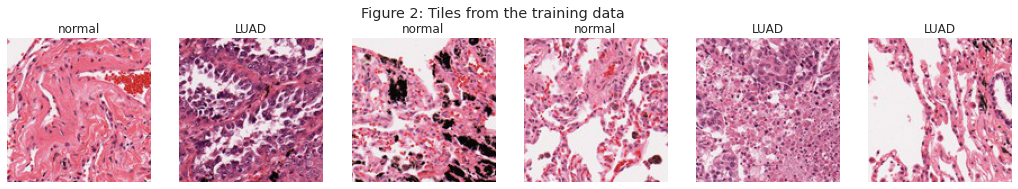

In [307]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([2000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Further, we inspect visually how many tiles there are per patient (due to different sizes of slides and amount of slides per patient): 

Total number of tiles: 95,359


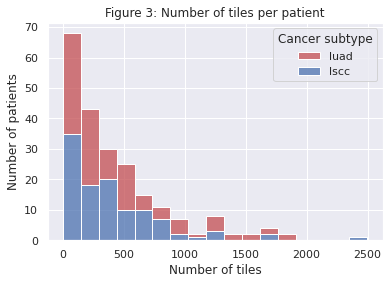

In [308]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and depicted in the image below. The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

![inceptionV3.png](idc-pathomics/inceptionV3.png)

In [314]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_20_first130slides.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_20_first200slides_2.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=30, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

Epoch 1/30
22/22 [==============================] - 37s 1s/step - loss: 1.4316 - auc_24: 0.7340 - val_loss: 3929993728.0000 - val_auc_24: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_120152/checkpoint_001/assets
Epoch 2/30
22/22 [==============================] - 26s 1s/step - loss: 1.0551 - auc_24: 0.8648 - val_loss: 90381680.0000 - val_auc_24: 0.4732
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_120152/checkpoint_002/assets
Epoch 3/30
22/22 [==============================] - 25s 1s/step - loss: 1.2561 - auc_24: 0.8806 - val_loss: 10217948.0000 - val_auc_24: 0.4732
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_120152/checkpoint_003/assets
Epoch 4/30
22/22 [==============================] - 25s 1s/step - loss: 1.0845 - auc_24: 0.8837 - val_loss: 389295.7500 - val_auc_24: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_120152/checkpoint_004/assets
Epoch 5/30
22/22 [==================

### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily repeatable. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification. Hereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [316]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

In [319]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_10slide_20tile_2.csv'), num_classes=3)
#test_dataset = Dataset('/home/jupyter/idc_input_vm/test_norm_luad_lscc_10slide_20tile_2.csv', num_classes=3)

predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_10slide_20tile_2.json'))

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.750               0.900               0.907
LUAD            0.469               0.688               0.630
LUSC            0.616               0.806               0.847
Micro           0.621               0.782               0.790

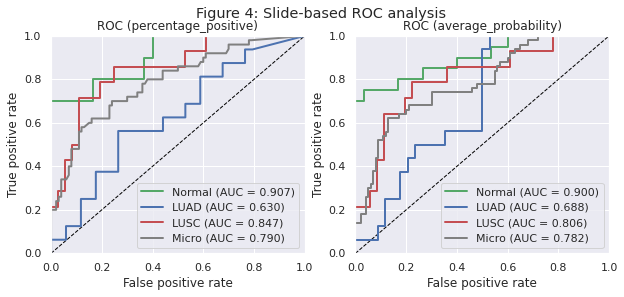

In [320]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table_10slide_20tile_2.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

In [261]:
%%capture --no-display
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import get_heatmap, plot_colormap_legend
from idc_pathomics.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]#'C3L-00913-22'#
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

Copying gs://idc_dev/6c60bc49-4275-4fab-a338-a7ff8aa11908.dcm...


MemoryError: 

/ [1 files][447.6 MiB/447.6 MiB]                                                
Operation completed over 1 objects/447.6 MiB.                                    
